# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0') # 200 steps/rewards total
env = gym.make('CartPole-v1') # 500 steps/rewards total

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
    #env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [6]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [7]:
train_episodes = 10000          # max number of episodes to learn from
max_steps = 2000                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [8]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [9]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [10]:
# Now train with experiences
saver = tf.train.Saver()
total_rewards_list = []
average_rewards_list = []

with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    total_rewards_deque = deque(maxlen=100)
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
            
        total_rewards_deque.append(total_reward)
        total_rewards_list.append((ep, total_reward))
        average_rewards_list.append((ep, np.mean(total_rewards_deque)))
        print('Episode: {}'.format(ep),
              'Aeverage Total reward: {:.2f}'.format(np.mean(total_rewards_deque)),
              'Total reward: {:.2f}'.format(total_reward),
              'Training loss: {:.4f}'.format(loss),
              'Explore P: {:.4f}'.format(explore_p))
        #print('\rEpisode {}\tTotal Average Score: {:.2f}'.format(ep, np.mean(total_rewards_deque)))  
        if np.mean(total_rewards_deque) >= 500:
            break
        
    saver.save(sess, "checkpoints/model.ckpt")

Episode: 1 Aeverage Total reward: 8.00 Total reward: 8.00 Training loss: 1.0883 Explore P: 0.9992
Episode: 2 Aeverage Total reward: 15.50 Total reward: 23.00 Training loss: 1.0741 Explore P: 0.9969
Episode: 3 Aeverage Total reward: 16.67 Total reward: 19.00 Training loss: 1.1762 Explore P: 0.9951
Episode: 4 Aeverage Total reward: 15.75 Total reward: 13.00 Training loss: 1.1562 Explore P: 0.9938
Episode: 5 Aeverage Total reward: 14.60 Total reward: 10.00 Training loss: 1.1445 Explore P: 0.9928
Episode: 6 Aeverage Total reward: 14.83 Total reward: 16.00 Training loss: 1.0128 Explore P: 0.9912
Episode: 7 Aeverage Total reward: 15.00 Total reward: 16.00 Training loss: 1.1579 Explore P: 0.9897
Episode: 8 Aeverage Total reward: 15.50 Total reward: 19.00 Training loss: 1.1674 Explore P: 0.9878
Episode: 9 Aeverage Total reward: 15.11 Total reward: 12.00 Training loss: 1.1358 Explore P: 0.9866
Episode: 10 Aeverage Total reward: 14.80 Total reward: 12.00 Training loss: 1.1286 Explore P: 0.9855
E

Episode: 84 Aeverage Total reward: 18.33 Total reward: 31.00 Training loss: 6.2961 Explore P: 0.8587
Episode: 85 Aeverage Total reward: 18.88 Total reward: 65.00 Training loss: 45.6035 Explore P: 0.8532
Episode: 86 Aeverage Total reward: 18.81 Total reward: 13.00 Training loss: 6.0026 Explore P: 0.8521
Episode: 87 Aeverage Total reward: 19.03 Total reward: 38.00 Training loss: 36.5908 Explore P: 0.8489
Episode: 88 Aeverage Total reward: 19.09 Total reward: 24.00 Training loss: 5.0715 Explore P: 0.8469
Episode: 89 Aeverage Total reward: 19.11 Total reward: 21.00 Training loss: 53.0401 Explore P: 0.8451
Episode: 90 Aeverage Total reward: 18.99 Total reward: 8.00 Training loss: 8.0667 Explore P: 0.8445
Episode: 91 Aeverage Total reward: 18.88 Total reward: 9.00 Training loss: 6.0935 Explore P: 0.8437
Episode: 92 Aeverage Total reward: 18.77 Total reward: 9.00 Training loss: 108.7181 Explore P: 0.8430
Episode: 93 Aeverage Total reward: 18.72 Total reward: 14.00 Training loss: 5.7229 Explor

Episode: 170 Aeverage Total reward: 15.55 Total reward: 20.00 Training loss: 137.6290 Explore P: 0.7529
Episode: 171 Aeverage Total reward: 15.55 Total reward: 15.00 Training loss: 35.9432 Explore P: 0.7517
Episode: 172 Aeverage Total reward: 15.58 Total reward: 23.00 Training loss: 6.0441 Explore P: 0.7500
Episode: 173 Aeverage Total reward: 15.62 Total reward: 16.00 Training loss: 55.0378 Explore P: 0.7489
Episode: 174 Aeverage Total reward: 15.59 Total reward: 11.00 Training loss: 49.7355 Explore P: 0.7480
Episode: 175 Aeverage Total reward: 15.59 Total reward: 11.00 Training loss: 37.4032 Explore P: 0.7472
Episode: 176 Aeverage Total reward: 15.52 Total reward: 10.00 Training loss: 4.5394 Explore P: 0.7465
Episode: 177 Aeverage Total reward: 15.48 Total reward: 16.00 Training loss: 4.1037 Explore P: 0.7453
Episode: 178 Aeverage Total reward: 15.49 Total reward: 11.00 Training loss: 39.5486 Explore P: 0.7445
Episode: 179 Aeverage Total reward: 15.48 Total reward: 13.00 Training loss

Episode: 253 Aeverage Total reward: 15.04 Total reward: 8.00 Training loss: 75.3359 Explore P: 0.6666
Episode: 254 Aeverage Total reward: 14.92 Total reward: 11.00 Training loss: 1.1454 Explore P: 0.6659
Episode: 255 Aeverage Total reward: 14.96 Total reward: 17.00 Training loss: 22.5462 Explore P: 0.6648
Episode: 256 Aeverage Total reward: 14.81 Total reward: 10.00 Training loss: 31.9512 Explore P: 0.6641
Episode: 257 Aeverage Total reward: 14.91 Total reward: 21.00 Training loss: 1.1991 Explore P: 0.6628
Episode: 258 Aeverage Total reward: 14.90 Total reward: 13.00 Training loss: 25.8224 Explore P: 0.6619
Episode: 259 Aeverage Total reward: 14.89 Total reward: 11.00 Training loss: 45.6379 Explore P: 0.6612
Episode: 260 Aeverage Total reward: 14.92 Total reward: 16.00 Training loss: 119.8807 Explore P: 0.6602
Episode: 261 Aeverage Total reward: 14.94 Total reward: 14.00 Training loss: 23.0528 Explore P: 0.6592
Episode: 262 Aeverage Total reward: 14.89 Total reward: 12.00 Training loss

Episode: 333 Aeverage Total reward: 15.88 Total reward: 40.00 Training loss: 1.1649 Explore P: 0.5849
Episode: 334 Aeverage Total reward: 16.11 Total reward: 40.00 Training loss: 24.9050 Explore P: 0.5826
Episode: 335 Aeverage Total reward: 16.16 Total reward: 17.00 Training loss: 14.5008 Explore P: 0.5816
Episode: 336 Aeverage Total reward: 16.16 Total reward: 14.00 Training loss: 1.4969 Explore P: 0.5808
Episode: 337 Aeverage Total reward: 16.38 Total reward: 36.00 Training loss: 13.4476 Explore P: 0.5788
Episode: 338 Aeverage Total reward: 16.38 Total reward: 19.00 Training loss: 12.8081 Explore P: 0.5777
Episode: 339 Aeverage Total reward: 16.44 Total reward: 15.00 Training loss: 13.2357 Explore P: 0.5769
Episode: 340 Aeverage Total reward: 16.54 Total reward: 20.00 Training loss: 1.1931 Explore P: 0.5757
Episode: 341 Aeverage Total reward: 16.60 Total reward: 16.00 Training loss: 1.0858 Explore P: 0.5748
Episode: 342 Aeverage Total reward: 16.69 Total reward: 27.00 Training loss: 

Episode: 413 Aeverage Total reward: 25.07 Total reward: 22.00 Training loss: 26.6071 Explore P: 0.4783
Episode: 414 Aeverage Total reward: 25.16 Total reward: 19.00 Training loss: 1.8159 Explore P: 0.4774
Episode: 415 Aeverage Total reward: 25.29 Total reward: 24.00 Training loss: 12.9522 Explore P: 0.4763
Episode: 416 Aeverage Total reward: 25.36 Total reward: 25.00 Training loss: 12.3129 Explore P: 0.4751
Episode: 417 Aeverage Total reward: 25.41 Total reward: 25.00 Training loss: 1.2106 Explore P: 0.4740
Episode: 418 Aeverage Total reward: 25.26 Total reward: 26.00 Training loss: 34.2325 Explore P: 0.4728
Episode: 419 Aeverage Total reward: 25.58 Total reward: 43.00 Training loss: 17.2348 Explore P: 0.4708
Episode: 420 Aeverage Total reward: 25.65 Total reward: 21.00 Training loss: 17.5430 Explore P: 0.4698
Episode: 421 Aeverage Total reward: 25.74 Total reward: 34.00 Training loss: 48.3473 Explore P: 0.4682
Episode: 422 Aeverage Total reward: 25.57 Total reward: 13.00 Training loss

Episode: 496 Aeverage Total reward: 29.44 Total reward: 29.00 Training loss: 10.2461 Explore P: 0.3720
Episode: 497 Aeverage Total reward: 29.60 Total reward: 30.00 Training loss: 28.6129 Explore P: 0.3709
Episode: 498 Aeverage Total reward: 29.58 Total reward: 17.00 Training loss: 15.9441 Explore P: 0.3703
Episode: 499 Aeverage Total reward: 29.80 Total reward: 39.00 Training loss: 1.6973 Explore P: 0.3689
Episode: 500 Aeverage Total reward: 30.02 Total reward: 34.00 Training loss: 18.9032 Explore P: 0.3677
Episode: 501 Aeverage Total reward: 30.15 Total reward: 38.00 Training loss: 29.4650 Explore P: 0.3663
Episode: 502 Aeverage Total reward: 30.20 Total reward: 31.00 Training loss: 36.6910 Explore P: 0.3652
Episode: 503 Aeverage Total reward: 30.42 Total reward: 46.00 Training loss: 23.8988 Explore P: 0.3636
Episode: 504 Aeverage Total reward: 30.52 Total reward: 39.00 Training loss: 36.6142 Explore P: 0.3622
Episode: 505 Aeverage Total reward: 30.99 Total reward: 78.00 Training los

Episode: 576 Aeverage Total reward: 51.00 Total reward: 101.00 Training loss: 1.3888 Explore P: 0.2442
Episode: 577 Aeverage Total reward: 51.69 Total reward: 101.00 Training loss: 141.9906 Explore P: 0.2418
Episode: 578 Aeverage Total reward: 51.41 Total reward: 30.00 Training loss: 100.4680 Explore P: 0.2411
Episode: 579 Aeverage Total reward: 51.77 Total reward: 60.00 Training loss: 1.6161 Explore P: 0.2397
Episode: 580 Aeverage Total reward: 51.82 Total reward: 32.00 Training loss: 1.6442 Explore P: 0.2390
Episode: 581 Aeverage Total reward: 51.66 Total reward: 17.00 Training loss: 1.4369 Explore P: 0.2386
Episode: 582 Aeverage Total reward: 51.54 Total reward: 20.00 Training loss: 2.2211 Explore P: 0.2382
Episode: 583 Aeverage Total reward: 51.30 Total reward: 25.00 Training loss: 40.0206 Explore P: 0.2376
Episode: 584 Aeverage Total reward: 51.48 Total reward: 47.00 Training loss: 1.3500 Explore P: 0.2365
Episode: 585 Aeverage Total reward: 51.39 Total reward: 46.00 Training loss

Episode: 656 Aeverage Total reward: 58.86 Total reward: 214.00 Training loss: 0.8500 Explore P: 0.1541
Episode: 657 Aeverage Total reward: 60.89 Total reward: 257.00 Training loss: 1.5615 Explore P: 0.1504
Episode: 658 Aeverage Total reward: 61.06 Total reward: 69.00 Training loss: 1.5951 Explore P: 0.1494
Episode: 659 Aeverage Total reward: 62.36 Total reward: 228.00 Training loss: 1.1324 Explore P: 0.1463
Episode: 660 Aeverage Total reward: 64.26 Total reward: 214.00 Training loss: 1.8226 Explore P: 0.1434
Episode: 661 Aeverage Total reward: 65.40 Total reward: 140.00 Training loss: 1.1403 Explore P: 0.1416
Episode: 662 Aeverage Total reward: 66.14 Total reward: 104.00 Training loss: 1.4209 Explore P: 0.1402
Episode: 663 Aeverage Total reward: 68.89 Total reward: 308.00 Training loss: 51.8190 Explore P: 0.1362
Episode: 664 Aeverage Total reward: 69.43 Total reward: 99.00 Training loss: 89.4337 Explore P: 0.1350
Episode: 665 Aeverage Total reward: 70.12 Total reward: 110.00 Training l

Episode: 736 Aeverage Total reward: 108.75 Total reward: 156.00 Training loss: 0.9056 Explore P: 0.0692
Episode: 737 Aeverage Total reward: 109.87 Total reward: 170.00 Training loss: 0.3985 Explore P: 0.0682
Episode: 738 Aeverage Total reward: 114.13 Total reward: 499.00 Training loss: 0.4067 Explore P: 0.0653
Episode: 739 Aeverage Total reward: 114.54 Total reward: 196.00 Training loss: 0.7441 Explore P: 0.0643
Episode: 740 Aeverage Total reward: 117.37 Total reward: 353.00 Training loss: 0.5869 Explore P: 0.0624
Episode: 741 Aeverage Total reward: 121.63 Total reward: 499.00 Training loss: 0.4017 Explore P: 0.0598
Episode: 742 Aeverage Total reward: 125.59 Total reward: 457.00 Training loss: 0.4431 Explore P: 0.0576
Episode: 743 Aeverage Total reward: 129.86 Total reward: 499.00 Training loss: 52.5553 Explore P: 0.0553
Episode: 744 Aeverage Total reward: 132.60 Total reward: 328.00 Training loss: 0.6798 Explore P: 0.0538
Episode: 745 Aeverage Total reward: 134.74 Total reward: 259.00

Episode: 815 Aeverage Total reward: 219.26 Total reward: 499.00 Training loss: 0.8631 Explore P: 0.0186
Episode: 816 Aeverage Total reward: 223.53 Total reward: 499.00 Training loss: 0.4928 Explore P: 0.0182
Episode: 817 Aeverage Total reward: 226.56 Total reward: 367.00 Training loss: 0.1910 Explore P: 0.0179
Episode: 818 Aeverage Total reward: 227.07 Total reward: 156.00 Training loss: 6.3111 Explore P: 0.0178
Episode: 819 Aeverage Total reward: 228.62 Total reward: 225.00 Training loss: 160.3953 Explore P: 0.0176
Episode: 820 Aeverage Total reward: 231.22 Total reward: 499.00 Training loss: 0.3316 Explore P: 0.0173
Episode: 821 Aeverage Total reward: 233.31 Total reward: 358.00 Training loss: 0.3375 Explore P: 0.0170
Episode: 822 Aeverage Total reward: 236.45 Total reward: 412.00 Training loss: 0.0744 Explore P: 0.0167
Episode: 823 Aeverage Total reward: 238.21 Total reward: 264.00 Training loss: 0.1682 Explore P: 0.0165
Episode: 824 Aeverage Total reward: 241.92 Total reward: 499.0

Episode: 895 Aeverage Total reward: 242.13 Total reward: 14.00 Training loss: 4.7770 Explore P: 0.0115
Episode: 896 Aeverage Total reward: 241.50 Total reward: 10.00 Training loss: 5.2423 Explore P: 0.0115
Episode: 897 Aeverage Total reward: 239.14 Total reward: 11.00 Training loss: 5.1999 Explore P: 0.0115
Episode: 898 Aeverage Total reward: 237.54 Total reward: 9.00 Training loss: 4.9563 Explore P: 0.0115
Episode: 899 Aeverage Total reward: 236.99 Total reward: 14.00 Training loss: 3.2687 Explore P: 0.0115
Episode: 900 Aeverage Total reward: 236.50 Total reward: 14.00 Training loss: 4.2645 Explore P: 0.0115
Episode: 901 Aeverage Total reward: 233.34 Total reward: 16.00 Training loss: 4.8376 Explore P: 0.0115
Episode: 902 Aeverage Total reward: 229.56 Total reward: 19.00 Training loss: 1.4156 Explore P: 0.0115
Episode: 903 Aeverage Total reward: 226.06 Total reward: 18.00 Training loss: 4.5651 Explore P: 0.0115
Episode: 904 Aeverage Total reward: 222.58 Total reward: 20.00 Training lo

Episode: 974 Aeverage Total reward: 318.62 Total reward: 496.00 Training loss: 0.5093 Explore P: 0.0101
Episode: 975 Aeverage Total reward: 322.95 Total reward: 447.00 Training loss: 0.4168 Explore P: 0.0101
Episode: 976 Aeverage Total reward: 327.32 Total reward: 450.00 Training loss: 0.8873 Explore P: 0.0101
Episode: 977 Aeverage Total reward: 331.40 Total reward: 423.00 Training loss: 0.6001 Explore P: 0.0101
Episode: 978 Aeverage Total reward: 335.83 Total reward: 457.00 Training loss: 0.3181 Explore P: 0.0101
Episode: 979 Aeverage Total reward: 340.21 Total reward: 450.00 Training loss: 127.5290 Explore P: 0.0101
Episode: 980 Aeverage Total reward: 344.60 Total reward: 453.00 Training loss: 0.3353 Explore P: 0.0100
Episode: 981 Aeverage Total reward: 348.24 Total reward: 464.00 Training loss: 0.4955 Explore P: 0.0100
Episode: 982 Aeverage Total reward: 352.51 Total reward: 441.00 Training loss: 0.2945 Explore P: 0.0100
Episode: 983 Aeverage Total reward: 356.50 Total reward: 412.0

Episode: 1053 Aeverage Total reward: 475.96 Total reward: 499.00 Training loss: 0.2041 Explore P: 0.0100
Episode: 1054 Aeverage Total reward: 475.96 Total reward: 499.00 Training loss: 415.5245 Explore P: 0.0100
Episode: 1055 Aeverage Total reward: 475.96 Total reward: 499.00 Training loss: 0.0897 Explore P: 0.0100
Episode: 1056 Aeverage Total reward: 475.96 Total reward: 499.00 Training loss: 0.1513 Explore P: 0.0100
Episode: 1057 Aeverage Total reward: 475.96 Total reward: 499.00 Training loss: 0.1638 Explore P: 0.0100
Episode: 1058 Aeverage Total reward: 476.28 Total reward: 499.00 Training loss: 0.1447 Explore P: 0.0100
Episode: 1059 Aeverage Total reward: 477.52 Total reward: 499.00 Training loss: 0.1554 Explore P: 0.0100
Episode: 1060 Aeverage Total reward: 478.21 Total reward: 499.00 Training loss: 0.0915 Explore P: 0.0100
Episode: 1061 Aeverage Total reward: 479.08 Total reward: 499.00 Training loss: 0.1925 Explore P: 0.0100
Episode: 1062 Aeverage Total reward: 480.58 Total rew

Episode: 1131 Aeverage Total reward: 498.92 Total reward: 499.00 Training loss: 0.2231 Explore P: 0.0100
Episode: 1132 Aeverage Total reward: 498.92 Total reward: 499.00 Training loss: 0.3771 Explore P: 0.0100
Episode: 1133 Aeverage Total reward: 498.92 Total reward: 499.00 Training loss: 0.1352 Explore P: 0.0100
Episode: 1134 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1930 Explore P: 0.0100
Episode: 1135 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1430 Explore P: 0.0100
Episode: 1136 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2028 Explore P: 0.0100
Episode: 1137 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0639 Explore P: 0.0100
Episode: 1138 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1305 Explore P: 0.0100
Episode: 1139 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0948 Explore P: 0.0100
Episode: 1140 Aeverage Total reward: 499.00 Total rewar

Episode: 1210 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0943 Explore P: 0.0100
Episode: 1211 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0860 Explore P: 0.0100
Episode: 1212 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0320 Explore P: 0.0100
Episode: 1213 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1306 Explore P: 0.0100
Episode: 1214 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0491 Explore P: 0.0100
Episode: 1215 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1352 Explore P: 0.0100
Episode: 1216 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0379 Explore P: 0.0100
Episode: 1217 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0658 Explore P: 0.0100
Episode: 1218 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0674 Explore P: 0.0100
Episode: 1219 Aeverage Total reward: 499.00 Total rewar

Episode: 1288 Aeverage Total reward: 497.17 Total reward: 499.00 Training loss: 0.2803 Explore P: 0.0100
Episode: 1289 Aeverage Total reward: 497.17 Total reward: 499.00 Training loss: 0.1468 Explore P: 0.0100
Episode: 1290 Aeverage Total reward: 497.17 Total reward: 499.00 Training loss: 0.1439 Explore P: 0.0100
Episode: 1291 Aeverage Total reward: 497.17 Total reward: 499.00 Training loss: 0.1393 Explore P: 0.0100
Episode: 1292 Aeverage Total reward: 497.17 Total reward: 499.00 Training loss: 0.2706 Explore P: 0.0100
Episode: 1293 Aeverage Total reward: 497.17 Total reward: 499.00 Training loss: 0.1259 Explore P: 0.0100
Episode: 1294 Aeverage Total reward: 497.17 Total reward: 499.00 Training loss: 0.1555 Explore P: 0.0100
Episode: 1295 Aeverage Total reward: 497.17 Total reward: 499.00 Training loss: 0.1854 Explore P: 0.0100
Episode: 1296 Aeverage Total reward: 497.17 Total reward: 499.00 Training loss: 0.1696 Explore P: 0.0100
Episode: 1297 Aeverage Total reward: 497.17 Total rewar

Episode: 1367 Aeverage Total reward: 483.26 Total reward: 499.00 Training loss: 0.3559 Explore P: 0.0100
Episode: 1368 Aeverage Total reward: 483.26 Total reward: 499.00 Training loss: 0.2242 Explore P: 0.0100
Episode: 1369 Aeverage Total reward: 483.26 Total reward: 499.00 Training loss: 0.3973 Explore P: 0.0100
Episode: 1370 Aeverage Total reward: 483.26 Total reward: 499.00 Training loss: 0.3186 Explore P: 0.0100
Episode: 1371 Aeverage Total reward: 483.26 Total reward: 499.00 Training loss: 0.2021 Explore P: 0.0100
Episode: 1372 Aeverage Total reward: 485.09 Total reward: 499.00 Training loss: 0.1488 Explore P: 0.0100
Episode: 1373 Aeverage Total reward: 485.09 Total reward: 499.00 Training loss: 0.1524 Explore P: 0.0100
Episode: 1374 Aeverage Total reward: 485.09 Total reward: 499.00 Training loss: 0.1113 Explore P: 0.0100
Episode: 1375 Aeverage Total reward: 485.09 Total reward: 499.00 Training loss: 0.2488 Explore P: 0.0100
Episode: 1376 Aeverage Total reward: 485.09 Total rewar

Episode: 1446 Aeverage Total reward: 498.37 Total reward: 499.00 Training loss: 0.1017 Explore P: 0.0100
Episode: 1447 Aeverage Total reward: 498.37 Total reward: 499.00 Training loss: 0.1021 Explore P: 0.0100
Episode: 1448 Aeverage Total reward: 498.37 Total reward: 499.00 Training loss: 0.0824 Explore P: 0.0100
Episode: 1449 Aeverage Total reward: 498.37 Total reward: 499.00 Training loss: 0.0838 Explore P: 0.0100
Episode: 1450 Aeverage Total reward: 498.37 Total reward: 499.00 Training loss: 0.1642 Explore P: 0.0100
Episode: 1451 Aeverage Total reward: 494.00 Total reward: 62.00 Training loss: 0.0873 Explore P: 0.0100
Episode: 1452 Aeverage Total reward: 489.78 Total reward: 35.00 Training loss: 0.1245 Explore P: 0.0100
Episode: 1453 Aeverage Total reward: 485.28 Total reward: 44.00 Training loss: 0.0348 Explore P: 0.0100
Episode: 1454 Aeverage Total reward: 485.28 Total reward: 499.00 Training loss: 0.1784 Explore P: 0.0100
Episode: 1455 Aeverage Total reward: 485.15 Total reward: 

Episode: 1525 Aeverage Total reward: 473.02 Total reward: 499.00 Training loss: 0.0681 Explore P: 0.0100
Episode: 1526 Aeverage Total reward: 473.02 Total reward: 499.00 Training loss: 0.1102 Explore P: 0.0100
Episode: 1527 Aeverage Total reward: 473.02 Total reward: 499.00 Training loss: 0.0880 Explore P: 0.0100
Episode: 1528 Aeverage Total reward: 473.02 Total reward: 499.00 Training loss: 0.0607 Explore P: 0.0100
Episode: 1529 Aeverage Total reward: 473.02 Total reward: 499.00 Training loss: 0.0992 Explore P: 0.0100
Episode: 1530 Aeverage Total reward: 473.02 Total reward: 499.00 Training loss: 0.1978 Explore P: 0.0100
Episode: 1531 Aeverage Total reward: 473.02 Total reward: 499.00 Training loss: 0.2011 Explore P: 0.0100
Episode: 1532 Aeverage Total reward: 473.02 Total reward: 499.00 Training loss: 0.0879 Explore P: 0.0100
Episode: 1533 Aeverage Total reward: 473.02 Total reward: 499.00 Training loss: 0.1445 Explore P: 0.0100
Episode: 1534 Aeverage Total reward: 473.02 Total rewar

Episode: 1608 Aeverage Total reward: 361.59 Total reward: 14.00 Training loss: 6.8963 Explore P: 0.0100
Episode: 1609 Aeverage Total reward: 356.70 Total reward: 10.00 Training loss: 1691.9684 Explore P: 0.0100
Episode: 1610 Aeverage Total reward: 351.82 Total reward: 11.00 Training loss: 12.5243 Explore P: 0.0100
Episode: 1611 Aeverage Total reward: 346.94 Total reward: 11.00 Training loss: 2237.9194 Explore P: 0.0100
Episode: 1612 Aeverage Total reward: 342.03 Total reward: 8.00 Training loss: 11.1097 Explore P: 0.0100
Episode: 1613 Aeverage Total reward: 337.15 Total reward: 11.00 Training loss: 10.2735 Explore P: 0.0100
Episode: 1614 Aeverage Total reward: 332.26 Total reward: 10.00 Training loss: 2199.8130 Explore P: 0.0100
Episode: 1615 Aeverage Total reward: 327.36 Total reward: 9.00 Training loss: 5.8613 Explore P: 0.0100
Episode: 1616 Aeverage Total reward: 322.48 Total reward: 11.00 Training loss: 7.3632 Explore P: 0.0100
Episode: 1617 Aeverage Total reward: 317.58 Total rewa

Episode: 1686 Aeverage Total reward: 294.37 Total reward: 499.00 Training loss: 0.0582 Explore P: 0.0100
Episode: 1687 Aeverage Total reward: 299.22 Total reward: 499.00 Training loss: 0.1044 Explore P: 0.0100
Episode: 1688 Aeverage Total reward: 299.22 Total reward: 499.00 Training loss: 364.2107 Explore P: 0.0100
Episode: 1689 Aeverage Total reward: 299.22 Total reward: 499.00 Training loss: 0.1924 Explore P: 0.0100
Episode: 1690 Aeverage Total reward: 300.53 Total reward: 499.00 Training loss: 0.4500 Explore P: 0.0100
Episode: 1691 Aeverage Total reward: 304.67 Total reward: 499.00 Training loss: 0.2632 Explore P: 0.0100
Episode: 1692 Aeverage Total reward: 309.55 Total reward: 499.00 Training loss: 0.1034 Explore P: 0.0100
Episode: 1693 Aeverage Total reward: 314.42 Total reward: 499.00 Training loss: 0.2185 Explore P: 0.0100
Episode: 1694 Aeverage Total reward: 319.33 Total reward: 499.00 Training loss: 0.4573 Explore P: 0.0100
Episode: 1695 Aeverage Total reward: 324.21 Total rew

Episode: 1764 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1171 Explore P: 0.0100
Episode: 1765 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0727 Explore P: 0.0100
Episode: 1766 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0722 Explore P: 0.0100
Episode: 1767 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 271.4123 Explore P: 0.0100
Episode: 1768 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1034 Explore P: 0.0100
Episode: 1769 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2737 Explore P: 0.0100
Episode: 1770 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0363 Explore P: 0.0100
Episode: 1771 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0635 Explore P: 0.0100
Episode: 1772 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0770 Explore P: 0.0100
Episode: 1773 Aeverage Total reward: 499.00 Total rew

Episode: 1842 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0574 Explore P: 0.0100
Episode: 1843 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.3784 Explore P: 0.0100
Episode: 1844 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1658 Explore P: 0.0100
Episode: 1845 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1251 Explore P: 0.0100
Episode: 1846 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.4930 Explore P: 0.0100
Episode: 1847 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2159 Explore P: 0.0100
Episode: 1848 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1738 Explore P: 0.0100
Episode: 1849 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1548 Explore P: 0.0100
Episode: 1850 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0828 Explore P: 0.0100
Episode: 1851 Aeverage Total reward: 499.00 Total rewar

Episode: 1921 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0849 Explore P: 0.0100
Episode: 1922 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1459 Explore P: 0.0100
Episode: 1923 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1096 Explore P: 0.0100
Episode: 1924 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.3729 Explore P: 0.0100
Episode: 1925 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2604 Explore P: 0.0100
Episode: 1926 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1729 Explore P: 0.0100
Episode: 1927 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.3940 Explore P: 0.0100
Episode: 1928 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0699 Explore P: 0.0100
Episode: 1929 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2606 Explore P: 0.0100
Episode: 1930 Aeverage Total reward: 499.00 Total rewar

Episode: 1999 Aeverage Total reward: 446.38 Total reward: 338.00 Training loss: 0.0853 Explore P: 0.0100
Episode: 2000 Aeverage Total reward: 444.74 Total reward: 335.00 Training loss: 0.0786 Explore P: 0.0100
Episode: 2001 Aeverage Total reward: 443.20 Total reward: 345.00 Training loss: 0.0838 Explore P: 0.0100
Episode: 2002 Aeverage Total reward: 441.40 Total reward: 319.00 Training loss: 0.1618 Explore P: 0.0100
Episode: 2003 Aeverage Total reward: 439.93 Total reward: 352.00 Training loss: 0.0637 Explore P: 0.0100
Episode: 2004 Aeverage Total reward: 438.19 Total reward: 325.00 Training loss: 0.2024 Explore P: 0.0100
Episode: 2005 Aeverage Total reward: 436.68 Total reward: 348.00 Training loss: 0.0559 Explore P: 0.0100
Episode: 2006 Aeverage Total reward: 435.13 Total reward: 344.00 Training loss: 0.1043 Explore P: 0.0100
Episode: 2007 Aeverage Total reward: 433.48 Total reward: 334.00 Training loss: 0.0953 Explore P: 0.0100
Episode: 2008 Aeverage Total reward: 431.84 Total rewar

Episode: 2077 Aeverage Total reward: 331.90 Total reward: 295.00 Training loss: 1.5185 Explore P: 0.0100
Episode: 2078 Aeverage Total reward: 331.37 Total reward: 309.00 Training loss: 0.0324 Explore P: 0.0100
Episode: 2079 Aeverage Total reward: 330.81 Total reward: 305.00 Training loss: 0.0547 Explore P: 0.0100
Episode: 2080 Aeverage Total reward: 329.99 Total reward: 301.00 Training loss: 0.0193 Explore P: 0.0100
Episode: 2081 Aeverage Total reward: 329.60 Total reward: 317.00 Training loss: 0.0401 Explore P: 0.0100
Episode: 2082 Aeverage Total reward: 329.51 Total reward: 329.00 Training loss: 0.0266 Explore P: 0.0100
Episode: 2083 Aeverage Total reward: 328.83 Total reward: 300.00 Training loss: 0.0438 Explore P: 0.0100
Episode: 2084 Aeverage Total reward: 328.18 Total reward: 306.00 Training loss: 0.0533 Explore P: 0.0100
Episode: 2085 Aeverage Total reward: 328.30 Total reward: 373.00 Training loss: 0.0566 Explore P: 0.0100
Episode: 2086 Aeverage Total reward: 328.26 Total rewar

Episode: 2156 Aeverage Total reward: 306.72 Total reward: 307.00 Training loss: 0.0438 Explore P: 0.0100
Episode: 2157 Aeverage Total reward: 306.67 Total reward: 317.00 Training loss: 0.0133 Explore P: 0.0100
Episode: 2158 Aeverage Total reward: 306.66 Total reward: 333.00 Training loss: 0.0313 Explore P: 0.0100
Episode: 2159 Aeverage Total reward: 306.52 Total reward: 303.00 Training loss: 0.0162 Explore P: 0.0100
Episode: 2160 Aeverage Total reward: 306.75 Total reward: 323.00 Training loss: 0.0393 Explore P: 0.0100
Episode: 2161 Aeverage Total reward: 306.36 Total reward: 295.00 Training loss: 0.0123 Explore P: 0.0100
Episode: 2162 Aeverage Total reward: 306.53 Total reward: 321.00 Training loss: 0.1077 Explore P: 0.0100
Episode: 2163 Aeverage Total reward: 306.33 Total reward: 297.00 Training loss: 0.0281 Explore P: 0.0100
Episode: 2164 Aeverage Total reward: 306.15 Total reward: 301.00 Training loss: 0.0078 Explore P: 0.0100
Episode: 2165 Aeverage Total reward: 306.10 Total rewar

Episode: 2238 Aeverage Total reward: 297.40 Total reward: 55.00 Training loss: 0.3812 Explore P: 0.0100
Episode: 2239 Aeverage Total reward: 294.32 Total reward: 17.00 Training loss: 0.4436 Explore P: 0.0100
Episode: 2240 Aeverage Total reward: 291.48 Total reward: 13.00 Training loss: 0.9770 Explore P: 0.0100
Episode: 2241 Aeverage Total reward: 288.42 Total reward: 9.00 Training loss: 1.0097 Explore P: 0.0100
Episode: 2242 Aeverage Total reward: 285.29 Total reward: 13.00 Training loss: 1.2267 Explore P: 0.0100
Episode: 2243 Aeverage Total reward: 282.33 Total reward: 8.00 Training loss: 1.2248 Explore P: 0.0100
Episode: 2244 Aeverage Total reward: 279.45 Total reward: 12.00 Training loss: 0.6031 Explore P: 0.0100
Episode: 2245 Aeverage Total reward: 276.68 Total reward: 16.00 Training loss: 0.5565 Explore P: 0.0100
Episode: 2246 Aeverage Total reward: 273.84 Total reward: 15.00 Training loss: 0.9672 Explore P: 0.0100
Episode: 2247 Aeverage Total reward: 270.94 Total reward: 10.00 Tr

Episode: 2317 Aeverage Total reward: 134.84 Total reward: 314.00 Training loss: 652.1685 Explore P: 0.0100
Episode: 2318 Aeverage Total reward: 134.07 Total reward: 280.00 Training loss: 0.6882 Explore P: 0.0100
Episode: 2319 Aeverage Total reward: 135.50 Total reward: 499.00 Training loss: 0.7121 Explore P: 0.0100
Episode: 2320 Aeverage Total reward: 137.22 Total reward: 499.00 Training loss: 1.0980 Explore P: 0.0100
Episode: 2321 Aeverage Total reward: 137.66 Total reward: 368.00 Training loss: 7.8512 Explore P: 0.0100
Episode: 2322 Aeverage Total reward: 138.85 Total reward: 499.00 Training loss: 0.3763 Explore P: 0.0100
Episode: 2323 Aeverage Total reward: 139.70 Total reward: 499.00 Training loss: 0.3031 Explore P: 0.0100
Episode: 2324 Aeverage Total reward: 141.04 Total reward: 499.00 Training loss: 0.4768 Explore P: 0.0100
Episode: 2325 Aeverage Total reward: 142.49 Total reward: 499.00 Training loss: 0.8331 Explore P: 0.0100
Episode: 2326 Aeverage Total reward: 142.60 Total rew

Episode: 2395 Aeverage Total reward: 385.42 Total reward: 402.00 Training loss: 0.1087 Explore P: 0.0100
Episode: 2396 Aeverage Total reward: 389.05 Total reward: 380.00 Training loss: 0.0554 Explore P: 0.0100
Episode: 2397 Aeverage Total reward: 393.02 Total reward: 408.00 Training loss: 0.0773 Explore P: 0.0100
Episode: 2398 Aeverage Total reward: 396.98 Total reward: 405.00 Training loss: 0.0507 Explore P: 0.0100
Episode: 2399 Aeverage Total reward: 400.47 Total reward: 357.00 Training loss: 0.0563 Explore P: 0.0100
Episode: 2400 Aeverage Total reward: 405.03 Total reward: 465.00 Training loss: 0.0460 Explore P: 0.0100
Episode: 2401 Aeverage Total reward: 408.71 Total reward: 390.00 Training loss: 0.0586 Explore P: 0.0100
Episode: 2402 Aeverage Total reward: 407.87 Total reward: 415.00 Training loss: 0.0270 Explore P: 0.0100
Episode: 2403 Aeverage Total reward: 406.54 Total reward: 366.00 Training loss: 0.0548 Explore P: 0.0100
Episode: 2404 Aeverage Total reward: 405.62 Total rewar

Episode: 2474 Aeverage Total reward: 263.02 Total reward: 101.00 Training loss: 3.4261 Explore P: 0.0100
Episode: 2475 Aeverage Total reward: 259.94 Total reward: 20.00 Training loss: 2.6769 Explore P: 0.0100
Episode: 2476 Aeverage Total reward: 256.90 Total reward: 17.00 Training loss: 3.9835 Explore P: 0.0100
Episode: 2477 Aeverage Total reward: 253.49 Total reward: 12.00 Training loss: 1700.9709 Explore P: 0.0100
Episode: 2478 Aeverage Total reward: 250.13 Total reward: 8.00 Training loss: 1.9897 Explore P: 0.0100
Episode: 2479 Aeverage Total reward: 246.28 Total reward: 16.00 Training loss: 2.4846 Explore P: 0.0100
Episode: 2480 Aeverage Total reward: 242.62 Total reward: 12.00 Training loss: 2.1980 Explore P: 0.0100
Episode: 2481 Aeverage Total reward: 239.08 Total reward: 17.00 Training loss: 2.5323 Explore P: 0.0100
Episode: 2482 Aeverage Total reward: 235.66 Total reward: 17.00 Training loss: 2.1947 Explore P: 0.0100
Episode: 2483 Aeverage Total reward: 232.36 Total reward: 11.

Episode: 2553 Aeverage Total reward: 210.48 Total reward: 247.00 Training loss: 0.1925 Explore P: 0.0100
Episode: 2554 Aeverage Total reward: 213.24 Total reward: 286.00 Training loss: 0.1055 Explore P: 0.0100
Episode: 2555 Aeverage Total reward: 216.12 Total reward: 296.00 Training loss: 0.2933 Explore P: 0.0100
Episode: 2556 Aeverage Total reward: 218.54 Total reward: 250.00 Training loss: 0.1873 Explore P: 0.0100
Episode: 2557 Aeverage Total reward: 220.76 Total reward: 233.00 Training loss: 0.3061 Explore P: 0.0100
Episode: 2558 Aeverage Total reward: 222.88 Total reward: 221.00 Training loss: 0.1645 Explore P: 0.0100
Episode: 2559 Aeverage Total reward: 225.09 Total reward: 229.00 Training loss: 0.5760 Explore P: 0.0100
Episode: 2560 Aeverage Total reward: 227.22 Total reward: 223.00 Training loss: 0.1744 Explore P: 0.0100
Episode: 2561 Aeverage Total reward: 230.05 Total reward: 291.00 Training loss: 1.0044 Explore P: 0.0100
Episode: 2562 Aeverage Total reward: 232.87 Total rewar

Episode: 2631 Aeverage Total reward: 323.96 Total reward: 295.00 Training loss: 5.5751 Explore P: 0.0100
Episode: 2632 Aeverage Total reward: 322.02 Total reward: 305.00 Training loss: 0.0557 Explore P: 0.0100
Episode: 2633 Aeverage Total reward: 321.48 Total reward: 308.00 Training loss: 0.0996 Explore P: 0.0100
Episode: 2634 Aeverage Total reward: 320.94 Total reward: 329.00 Training loss: 0.0797 Explore P: 0.0100
Episode: 2635 Aeverage Total reward: 322.28 Total reward: 441.00 Training loss: 0.2232 Explore P: 0.0100
Episode: 2636 Aeverage Total reward: 323.29 Total reward: 499.00 Training loss: 0.0265 Explore P: 0.0100
Episode: 2637 Aeverage Total reward: 322.72 Total reward: 442.00 Training loss: 0.0393 Explore P: 0.0100
Episode: 2638 Aeverage Total reward: 321.19 Total reward: 279.00 Training loss: 0.0280 Explore P: 0.0100
Episode: 2639 Aeverage Total reward: 322.88 Total reward: 461.00 Training loss: 0.2905 Explore P: 0.0100
Episode: 2640 Aeverage Total reward: 323.50 Total rewar

Episode: 2710 Aeverage Total reward: 379.16 Total reward: 171.00 Training loss: 4.3815 Explore P: 0.0100
Episode: 2711 Aeverage Total reward: 378.72 Total reward: 298.00 Training loss: 2.7640 Explore P: 0.0100
Episode: 2712 Aeverage Total reward: 379.94 Total reward: 499.00 Training loss: 0.7731 Explore P: 0.0100
Episode: 2713 Aeverage Total reward: 381.32 Total reward: 499.00 Training loss: 0.2381 Explore P: 0.0100
Episode: 2714 Aeverage Total reward: 381.32 Total reward: 499.00 Training loss: 3.4213 Explore P: 0.0100
Episode: 2715 Aeverage Total reward: 381.32 Total reward: 499.00 Training loss: 4.0611 Explore P: 0.0100
Episode: 2716 Aeverage Total reward: 381.32 Total reward: 499.00 Training loss: 3.8891 Explore P: 0.0100
Episode: 2717 Aeverage Total reward: 376.43 Total reward: 10.00 Training loss: 4.8859 Explore P: 0.0100
Episode: 2718 Aeverage Total reward: 371.55 Total reward: 11.00 Training loss: 8.7933 Explore P: 0.0100
Episode: 2719 Aeverage Total reward: 366.69 Total reward:

Episode: 2790 Aeverage Total reward: 100.78 Total reward: 99.00 Training loss: 2232.6526 Explore P: 0.0100
Episode: 2791 Aeverage Total reward: 100.35 Total reward: 128.00 Training loss: 10.1525 Explore P: 0.0100
Episode: 2792 Aeverage Total reward: 100.80 Total reward: 159.00 Training loss: 19.7458 Explore P: 0.0100
Episode: 2793 Aeverage Total reward: 100.91 Total reward: 165.00 Training loss: 10.2210 Explore P: 0.0100
Episode: 2794 Aeverage Total reward: 103.10 Total reward: 341.00 Training loss: 6.3431 Explore P: 0.0100
Episode: 2795 Aeverage Total reward: 104.93 Total reward: 499.00 Training loss: 8.0968 Explore P: 0.0100
Episode: 2796 Aeverage Total reward: 104.93 Total reward: 499.00 Training loss: 10.4328 Explore P: 0.0100
Episode: 2797 Aeverage Total reward: 104.93 Total reward: 499.00 Training loss: 4.1870 Explore P: 0.0100
Episode: 2798 Aeverage Total reward: 104.93 Total reward: 499.00 Training loss: 8.2682 Explore P: 0.0100
Episode: 2799 Aeverage Total reward: 104.93 Total

Episode: 2868 Aeverage Total reward: 323.74 Total reward: 327.00 Training loss: 0.1454 Explore P: 0.0100
Episode: 2869 Aeverage Total reward: 326.80 Total reward: 316.00 Training loss: 0.2127 Explore P: 0.0100
Episode: 2870 Aeverage Total reward: 330.08 Total reward: 337.00 Training loss: 0.1146 Explore P: 0.0100
Episode: 2871 Aeverage Total reward: 333.24 Total reward: 327.00 Training loss: 0.1465 Explore P: 0.0100
Episode: 2872 Aeverage Total reward: 336.18 Total reward: 305.00 Training loss: 0.1667 Explore P: 0.0100
Episode: 2873 Aeverage Total reward: 339.70 Total reward: 361.00 Training loss: 0.2864 Explore P: 0.0100
Episode: 2874 Aeverage Total reward: 343.05 Total reward: 347.00 Training loss: 0.1105 Explore P: 0.0100
Episode: 2875 Aeverage Total reward: 346.30 Total reward: 336.00 Training loss: 0.1390 Explore P: 0.0100
Episode: 2876 Aeverage Total reward: 349.86 Total reward: 369.00 Training loss: 0.1032 Explore P: 0.0100
Episode: 2877 Aeverage Total reward: 353.45 Total rewar

Episode: 2946 Aeverage Total reward: 362.72 Total reward: 499.00 Training loss: 0.0769 Explore P: 0.0100
Episode: 2947 Aeverage Total reward: 364.38 Total reward: 499.00 Training loss: 0.0482 Explore P: 0.0100
Episode: 2948 Aeverage Total reward: 365.83 Total reward: 472.00 Training loss: 0.1249 Explore P: 0.0100
Episode: 2949 Aeverage Total reward: 367.42 Total reward: 499.00 Training loss: 0.1323 Explore P: 0.0100
Episode: 2950 Aeverage Total reward: 369.09 Total reward: 499.00 Training loss: 0.0428 Explore P: 0.0100
Episode: 2951 Aeverage Total reward: 370.93 Total reward: 499.00 Training loss: 0.0987 Explore P: 0.0100
Episode: 2952 Aeverage Total reward: 372.98 Total reward: 499.00 Training loss: 0.0704 Explore P: 0.0100
Episode: 2953 Aeverage Total reward: 374.54 Total reward: 499.00 Training loss: 0.5032 Explore P: 0.0100
Episode: 2954 Aeverage Total reward: 376.29 Total reward: 499.00 Training loss: 0.0765 Explore P: 0.0100
Episode: 2955 Aeverage Total reward: 377.80 Total rewar

Episode: 3030 Aeverage Total reward: 343.37 Total reward: 499.00 Training loss: 4.9052 Explore P: 0.0100
Episode: 3031 Aeverage Total reward: 343.21 Total reward: 421.00 Training loss: 1.1000 Explore P: 0.0100
Episode: 3032 Aeverage Total reward: 341.22 Total reward: 238.00 Training loss: 0.8841 Explore P: 0.0100
Episode: 3033 Aeverage Total reward: 338.24 Total reward: 193.00 Training loss: 4.9171 Explore P: 0.0100
Episode: 3034 Aeverage Total reward: 335.33 Total reward: 187.00 Training loss: 2.7489 Explore P: 0.0100
Episode: 3035 Aeverage Total reward: 332.13 Total reward: 169.00 Training loss: 0.6198 Explore P: 0.0100
Episode: 3036 Aeverage Total reward: 328.93 Total reward: 146.00 Training loss: 1.5271 Explore P: 0.0100
Episode: 3037 Aeverage Total reward: 326.10 Total reward: 162.00 Training loss: 4.1148 Explore P: 0.0100
Episode: 3038 Aeverage Total reward: 323.25 Total reward: 151.00 Training loss: 5.7430 Explore P: 0.0100
Episode: 3039 Aeverage Total reward: 319.89 Total rewar

Episode: 3108 Aeverage Total reward: 235.40 Total reward: 499.00 Training loss: 0.1542 Explore P: 0.0100
Episode: 3109 Aeverage Total reward: 240.30 Total reward: 499.00 Training loss: 0.1328 Explore P: 0.0100
Episode: 3110 Aeverage Total reward: 245.21 Total reward: 499.00 Training loss: 0.2952 Explore P: 0.0100
Episode: 3111 Aeverage Total reward: 250.12 Total reward: 499.00 Training loss: 0.0778 Explore P: 0.0100
Episode: 3112 Aeverage Total reward: 255.02 Total reward: 499.00 Training loss: 0.1636 Explore P: 0.0100
Episode: 3113 Aeverage Total reward: 259.91 Total reward: 499.00 Training loss: 0.1484 Explore P: 0.0100
Episode: 3114 Aeverage Total reward: 264.81 Total reward: 499.00 Training loss: 0.1029 Explore P: 0.0100
Episode: 3115 Aeverage Total reward: 269.69 Total reward: 499.00 Training loss: 0.4201 Explore P: 0.0100
Episode: 3116 Aeverage Total reward: 274.61 Total reward: 499.00 Training loss: 0.1541 Explore P: 0.0100
Episode: 3117 Aeverage Total reward: 279.50 Total rewar

Episode: 3186 Aeverage Total reward: 497.96 Total reward: 499.00 Training loss: 0.1219 Explore P: 0.0100
Episode: 3187 Aeverage Total reward: 497.96 Total reward: 499.00 Training loss: 0.2132 Explore P: 0.0100
Episode: 3188 Aeverage Total reward: 497.96 Total reward: 499.00 Training loss: 0.2066 Explore P: 0.0100
Episode: 3189 Aeverage Total reward: 497.96 Total reward: 499.00 Training loss: 0.2893 Explore P: 0.0100
Episode: 3190 Aeverage Total reward: 497.96 Total reward: 499.00 Training loss: 0.1467 Explore P: 0.0100
Episode: 3191 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2689 Explore P: 0.0100
Episode: 3192 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 309.5542 Explore P: 0.0100
Episode: 3193 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0895 Explore P: 0.0100
Episode: 3194 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0585 Explore P: 0.0100
Episode: 3195 Aeverage Total reward: 499.00 Total rew

Episode: 3264 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1246 Explore P: 0.0100
Episode: 3265 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2565 Explore P: 0.0100
Episode: 3266 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1027 Explore P: 0.0100
Episode: 3267 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1833 Explore P: 0.0100
Episode: 3268 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1885 Explore P: 0.0100
Episode: 3269 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0788 Explore P: 0.0100
Episode: 3270 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 357.6063 Explore P: 0.0100
Episode: 3271 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0938 Explore P: 0.0100
Episode: 3272 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.4100 Explore P: 0.0100
Episode: 3273 Aeverage Total reward: 499.00 Total rew

Episode: 3342 Aeverage Total reward: 479.20 Total reward: 499.00 Training loss: 1.1485 Explore P: 0.0100
Episode: 3343 Aeverage Total reward: 479.20 Total reward: 499.00 Training loss: 3.2352 Explore P: 0.0100
Episode: 3344 Aeverage Total reward: 479.20 Total reward: 499.00 Training loss: 1.1581 Explore P: 0.0100
Episode: 3345 Aeverage Total reward: 479.20 Total reward: 499.00 Training loss: 1.0393 Explore P: 0.0100
Episode: 3346 Aeverage Total reward: 479.20 Total reward: 499.00 Training loss: 1.9501 Explore P: 0.0100
Episode: 3347 Aeverage Total reward: 479.20 Total reward: 499.00 Training loss: 1.0906 Explore P: 0.0100
Episode: 3348 Aeverage Total reward: 479.20 Total reward: 499.00 Training loss: 1.1375 Explore P: 0.0100
Episode: 3349 Aeverage Total reward: 479.20 Total reward: 499.00 Training loss: 0.7005 Explore P: 0.0100
Episode: 3350 Aeverage Total reward: 479.20 Total reward: 499.00 Training loss: 0.6411 Explore P: 0.0100
Episode: 3351 Aeverage Total reward: 479.20 Total rewar

Episode: 3425 Aeverage Total reward: 204.79 Total reward: 8.00 Training loss: 67.3447 Explore P: 0.0100
Episode: 3426 Aeverage Total reward: 199.91 Total reward: 11.00 Training loss: 40.3370 Explore P: 0.0100
Episode: 3427 Aeverage Total reward: 198.39 Total reward: 11.00 Training loss: 53.3234 Explore P: 0.0100
Episode: 3428 Aeverage Total reward: 197.49 Total reward: 11.00 Training loss: 2578.5420 Explore P: 0.0100
Episode: 3429 Aeverage Total reward: 197.28 Total reward: 12.00 Training loss: 36.7879 Explore P: 0.0100
Episode: 3430 Aeverage Total reward: 197.14 Total reward: 10.00 Training loss: 47.9782 Explore P: 0.0100
Episode: 3431 Aeverage Total reward: 192.26 Total reward: 11.00 Training loss: 46.4440 Explore P: 0.0100
Episode: 3432 Aeverage Total reward: 187.39 Total reward: 12.00 Training loss: 7240.2607 Explore P: 0.0100
Episode: 3433 Aeverage Total reward: 182.50 Total reward: 10.00 Training loss: 49.3603 Explore P: 0.0100
Episode: 3434 Aeverage Total reward: 177.63 Total re

Episode: 3504 Aeverage Total reward: 226.76 Total reward: 499.00 Training loss: 0.7996 Explore P: 0.0100
Episode: 3505 Aeverage Total reward: 231.65 Total reward: 499.00 Training loss: 0.4235 Explore P: 0.0100
Episode: 3506 Aeverage Total reward: 236.54 Total reward: 499.00 Training loss: 0.3953 Explore P: 0.0100
Episode: 3507 Aeverage Total reward: 241.42 Total reward: 499.00 Training loss: 0.1633 Explore P: 0.0100
Episode: 3508 Aeverage Total reward: 246.29 Total reward: 499.00 Training loss: 1.0404 Explore P: 0.0100
Episode: 3509 Aeverage Total reward: 251.19 Total reward: 499.00 Training loss: 0.3074 Explore P: 0.0100
Episode: 3510 Aeverage Total reward: 256.10 Total reward: 499.00 Training loss: 0.2179 Explore P: 0.0100
Episode: 3511 Aeverage Total reward: 260.99 Total reward: 499.00 Training loss: 0.3658 Explore P: 0.0100
Episode: 3512 Aeverage Total reward: 265.87 Total reward: 499.00 Training loss: 0.4428 Explore P: 0.0100
Episode: 3513 Aeverage Total reward: 270.75 Total rewar

Episode: 3583 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2357 Explore P: 0.0100
Episode: 3584 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.3264 Explore P: 0.0100
Episode: 3585 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2613 Explore P: 0.0100
Episode: 3586 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1656 Explore P: 0.0100
Episode: 3587 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1404 Explore P: 0.0100
Episode: 3588 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2227 Explore P: 0.0100
Episode: 3589 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1387 Explore P: 0.0100
Episode: 3590 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0737 Explore P: 0.0100
Episode: 3591 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1231 Explore P: 0.0100
Episode: 3592 Aeverage Total reward: 499.00 Total rewar

Episode: 3661 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0676 Explore P: 0.0100
Episode: 3662 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0631 Explore P: 0.0100
Episode: 3663 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0990 Explore P: 0.0100
Episode: 3664 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0672 Explore P: 0.0100
Episode: 3665 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2790 Explore P: 0.0100
Episode: 3666 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1116 Explore P: 0.0100
Episode: 3667 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0830 Explore P: 0.0100
Episode: 3668 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0551 Explore P: 0.0100
Episode: 3669 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0855 Explore P: 0.0100
Episode: 3670 Aeverage Total reward: 499.00 Total rewar

Episode: 3740 Aeverage Total reward: 425.08 Total reward: 147.00 Training loss: 1699.0984 Explore P: 0.0100
Episode: 3741 Aeverage Total reward: 421.48 Total reward: 139.00 Training loss: 2024.3131 Explore P: 0.0100
Episode: 3742 Aeverage Total reward: 417.71 Total reward: 122.00 Training loss: 5.1651 Explore P: 0.0100
Episode: 3743 Aeverage Total reward: 414.02 Total reward: 130.00 Training loss: 3.7475 Explore P: 0.0100
Episode: 3744 Aeverage Total reward: 410.16 Total reward: 113.00 Training loss: 5.5076 Explore P: 0.0100
Episode: 3745 Aeverage Total reward: 406.20 Total reward: 103.00 Training loss: 7.6895 Explore P: 0.0100
Episode: 3746 Aeverage Total reward: 401.99 Total reward: 78.00 Training loss: 4.9965 Explore P: 0.0100
Episode: 3747 Aeverage Total reward: 397.87 Total reward: 87.00 Training loss: 12.7103 Explore P: 0.0100
Episode: 3748 Aeverage Total reward: 393.79 Total reward: 91.00 Training loss: 5.6057 Explore P: 0.0100
Episode: 3749 Aeverage Total reward: 389.50 Total r

Episode: 3822 Aeverage Total reward: 92.47 Total reward: 8.00 Training loss: 46.7814 Explore P: 0.0100
Episode: 3823 Aeverage Total reward: 90.63 Total reward: 7.00 Training loss: 64.8378 Explore P: 0.0100
Episode: 3824 Aeverage Total reward: 88.94 Total reward: 10.00 Training loss: 11025.8906 Explore P: 0.0100
Episode: 3825 Aeverage Total reward: 86.80 Total reward: 11.00 Training loss: 60.3836 Explore P: 0.0100
Episode: 3826 Aeverage Total reward: 84.18 Total reward: 7.00 Training loss: 69.4054 Explore P: 0.0100
Episode: 3827 Aeverage Total reward: 79.53 Total reward: 10.00 Training loss: 54.3546 Explore P: 0.0100
Episode: 3828 Aeverage Total reward: 74.97 Total reward: 12.00 Training loss: 87.1435 Explore P: 0.0100
Episode: 3829 Aeverage Total reward: 70.09 Total reward: 11.00 Training loss: 82.4312 Explore P: 0.0100
Episode: 3830 Aeverage Total reward: 65.91 Total reward: 8.00 Training loss: 62.1980 Explore P: 0.0100
Episode: 3831 Aeverage Total reward: 62.51 Total reward: 10.00 Tr

Episode: 3901 Aeverage Total reward: 282.10 Total reward: 499.00 Training loss: 0.2125 Explore P: 0.0100
Episode: 3902 Aeverage Total reward: 286.99 Total reward: 499.00 Training loss: 0.4149 Explore P: 0.0100
Episode: 3903 Aeverage Total reward: 291.90 Total reward: 499.00 Training loss: 0.1754 Explore P: 0.0100
Episode: 3904 Aeverage Total reward: 296.80 Total reward: 499.00 Training loss: 0.5220 Explore P: 0.0100
Episode: 3905 Aeverage Total reward: 301.69 Total reward: 499.00 Training loss: 329.7288 Explore P: 0.0100
Episode: 3906 Aeverage Total reward: 306.56 Total reward: 499.00 Training loss: 0.1744 Explore P: 0.0100
Episode: 3907 Aeverage Total reward: 311.44 Total reward: 499.00 Training loss: 0.1303 Explore P: 0.0100
Episode: 3908 Aeverage Total reward: 316.34 Total reward: 499.00 Training loss: 0.1353 Explore P: 0.0100
Episode: 3909 Aeverage Total reward: 321.23 Total reward: 499.00 Training loss: 0.3720 Explore P: 0.0100
Episode: 3910 Aeverage Total reward: 326.14 Total rew

Episode: 3979 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1527 Explore P: 0.0100
Episode: 3980 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.3656 Explore P: 0.0100
Episode: 3981 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2289 Explore P: 0.0100
Episode: 3982 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0298 Explore P: 0.0100
Episode: 3983 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.3326 Explore P: 0.0100
Episode: 3984 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1443 Explore P: 0.0100
Episode: 3985 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2431 Explore P: 0.0100
Episode: 3986 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1035 Explore P: 0.0100
Episode: 3987 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1469 Explore P: 0.0100
Episode: 3988 Aeverage Total reward: 499.00 Total rewar

Episode: 4057 Aeverage Total reward: 496.15 Total reward: 499.00 Training loss: 0.2238 Explore P: 0.0100
Episode: 4058 Aeverage Total reward: 496.15 Total reward: 499.00 Training loss: 0.1169 Explore P: 0.0100
Episode: 4059 Aeverage Total reward: 496.15 Total reward: 499.00 Training loss: 0.2541 Explore P: 0.0100
Episode: 4060 Aeverage Total reward: 496.15 Total reward: 499.00 Training loss: 0.1564 Explore P: 0.0100
Episode: 4061 Aeverage Total reward: 496.15 Total reward: 499.00 Training loss: 0.4984 Explore P: 0.0100
Episode: 4062 Aeverage Total reward: 495.07 Total reward: 391.00 Training loss: 0.1649 Explore P: 0.0100
Episode: 4063 Aeverage Total reward: 495.07 Total reward: 499.00 Training loss: 0.2461 Explore P: 0.0100
Episode: 4064 Aeverage Total reward: 495.07 Total reward: 499.00 Training loss: 0.2274 Explore P: 0.0100
Episode: 4065 Aeverage Total reward: 495.07 Total reward: 499.00 Training loss: 0.2027 Explore P: 0.0100
Episode: 4066 Aeverage Total reward: 495.07 Total rewar

Episode: 4136 Aeverage Total reward: 490.62 Total reward: 499.00 Training loss: 370.7527 Explore P: 0.0100
Episode: 4137 Aeverage Total reward: 490.62 Total reward: 499.00 Training loss: 0.1588 Explore P: 0.0100
Episode: 4138 Aeverage Total reward: 490.62 Total reward: 499.00 Training loss: 0.1450 Explore P: 0.0100
Episode: 4139 Aeverage Total reward: 490.62 Total reward: 499.00 Training loss: 0.0653 Explore P: 0.0100
Episode: 4140 Aeverage Total reward: 490.62 Total reward: 499.00 Training loss: 0.1767 Explore P: 0.0100
Episode: 4141 Aeverage Total reward: 490.62 Total reward: 499.00 Training loss: 0.1784 Explore P: 0.0100
Episode: 4142 Aeverage Total reward: 490.62 Total reward: 499.00 Training loss: 0.1135 Explore P: 0.0100
Episode: 4143 Aeverage Total reward: 490.62 Total reward: 499.00 Training loss: 0.1367 Explore P: 0.0100
Episode: 4144 Aeverage Total reward: 490.62 Total reward: 499.00 Training loss: 0.1511 Explore P: 0.0100
Episode: 4145 Aeverage Total reward: 490.62 Total rew

Episode: 4214 Aeverage Total reward: 497.93 Total reward: 499.00 Training loss: 0.2744 Explore P: 0.0100
Episode: 4215 Aeverage Total reward: 498.93 Total reward: 499.00 Training loss: 0.3143 Explore P: 0.0100
Episode: 4216 Aeverage Total reward: 496.30 Total reward: 236.00 Training loss: 0.4667 Explore P: 0.0100
Episode: 4217 Aeverage Total reward: 493.54 Total reward: 223.00 Training loss: 0.5302 Explore P: 0.0100
Episode: 4218 Aeverage Total reward: 490.32 Total reward: 177.00 Training loss: 0.7069 Explore P: 0.0100
Episode: 4219 Aeverage Total reward: 486.87 Total reward: 154.00 Training loss: 992.3105 Explore P: 0.0100
Episode: 4220 Aeverage Total reward: 483.49 Total reward: 161.00 Training loss: 1.2570 Explore P: 0.0100
Episode: 4221 Aeverage Total reward: 479.83 Total reward: 133.00 Training loss: 1.1488 Explore P: 0.0100
Episode: 4222 Aeverage Total reward: 475.84 Total reward: 100.00 Training loss: 1.3691 Explore P: 0.0100
Episode: 4223 Aeverage Total reward: 471.79 Total rew

Episode: 4295 Aeverage Total reward: 153.01 Total reward: 34.00 Training loss: 464.3570 Explore P: 0.0100
Episode: 4296 Aeverage Total reward: 148.46 Total reward: 44.00 Training loss: 4.6833 Explore P: 0.0100
Episode: 4297 Aeverage Total reward: 143.92 Total reward: 45.00 Training loss: 9.9066 Explore P: 0.0100
Episode: 4298 Aeverage Total reward: 139.30 Total reward: 37.00 Training loss: 10.3655 Explore P: 0.0100
Episode: 4299 Aeverage Total reward: 134.70 Total reward: 39.00 Training loss: 9.9576 Explore P: 0.0100
Episode: 4300 Aeverage Total reward: 130.08 Total reward: 37.00 Training loss: 15.6767 Explore P: 0.0100
Episode: 4301 Aeverage Total reward: 125.42 Total reward: 33.00 Training loss: 63.2203 Explore P: 0.0100
Episode: 4302 Aeverage Total reward: 120.88 Total reward: 45.00 Training loss: 3.6592 Explore P: 0.0100
Episode: 4303 Aeverage Total reward: 116.23 Total reward: 34.00 Training loss: 11.9354 Explore P: 0.0100
Episode: 4304 Aeverage Total reward: 111.61 Total reward: 

Episode: 4376 Aeverage Total reward: 46.83 Total reward: 55.00 Training loss: 53.4532 Explore P: 0.0100
Episode: 4377 Aeverage Total reward: 46.88 Total reward: 55.00 Training loss: 3066.4214 Explore P: 0.0100
Episode: 4378 Aeverage Total reward: 47.21 Total reward: 88.00 Training loss: 42.5385 Explore P: 0.0100
Episode: 4379 Aeverage Total reward: 47.67 Total reward: 85.00 Training loss: 2262.3643 Explore P: 0.0100
Episode: 4380 Aeverage Total reward: 47.89 Total reward: 70.00 Training loss: 87.0483 Explore P: 0.0100
Episode: 4381 Aeverage Total reward: 48.38 Total reward: 87.00 Training loss: 2067.3228 Explore P: 0.0100
Episode: 4382 Aeverage Total reward: 48.55 Total reward: 64.00 Training loss: 56.2749 Explore P: 0.0100
Episode: 4383 Aeverage Total reward: 48.71 Total reward: 57.00 Training loss: 2278.9175 Explore P: 0.0100
Episode: 4384 Aeverage Total reward: 48.56 Total reward: 23.00 Training loss: 1507.5671 Explore P: 0.0100
Episode: 4385 Aeverage Total reward: 48.28 Total rewar

Episode: 4455 Aeverage Total reward: 30.78 Total reward: 324.00 Training loss: 49.5863 Explore P: 0.0100
Episode: 4456 Aeverage Total reward: 34.80 Total reward: 499.00 Training loss: 50.0833 Explore P: 0.0100
Episode: 4457 Aeverage Total reward: 38.96 Total reward: 499.00 Training loss: 3267.6636 Explore P: 0.0100
Episode: 4458 Aeverage Total reward: 42.32 Total reward: 426.00 Training loss: 56.2745 Explore P: 0.0100
Episode: 4459 Aeverage Total reward: 44.25 Total reward: 271.00 Training loss: 54.6357 Explore P: 0.0100
Episode: 4460 Aeverage Total reward: 46.89 Total reward: 336.00 Training loss: 45.4779 Explore P: 0.0100
Episode: 4461 Aeverage Total reward: 48.73 Total reward: 265.00 Training loss: 1055.2356 Explore P: 0.0100
Episode: 4462 Aeverage Total reward: 51.11 Total reward: 311.00 Training loss: 208.8141 Explore P: 0.0100
Episode: 4463 Aeverage Total reward: 53.36 Total reward: 267.00 Training loss: 1006.4173 Explore P: 0.0100
Episode: 4464 Aeverage Total reward: 55.54 Total

Episode: 4533 Aeverage Total reward: 279.73 Total reward: 499.00 Training loss: 0.4183 Explore P: 0.0100
Episode: 4534 Aeverage Total reward: 283.67 Total reward: 406.00 Training loss: 0.3989 Explore P: 0.0100
Episode: 4535 Aeverage Total reward: 286.99 Total reward: 345.00 Training loss: 1.2408 Explore P: 0.0100
Episode: 4536 Aeverage Total reward: 291.82 Total reward: 499.00 Training loss: 0.3707 Explore P: 0.0100
Episode: 4537 Aeverage Total reward: 295.72 Total reward: 413.00 Training loss: 3.0807 Explore P: 0.0100
Episode: 4538 Aeverage Total reward: 297.35 Total reward: 188.00 Training loss: 0.4243 Explore P: 0.0100
Episode: 4539 Aeverage Total reward: 302.20 Total reward: 499.00 Training loss: 0.5820 Explore P: 0.0100
Episode: 4540 Aeverage Total reward: 307.07 Total reward: 499.00 Training loss: 0.2725 Explore P: 0.0100
Episode: 4541 Aeverage Total reward: 311.96 Total reward: 499.00 Training loss: 0.3310 Explore P: 0.0100
Episode: 4542 Aeverage Total reward: 313.75 Total rewar

Episode: 4611 Aeverage Total reward: 363.09 Total reward: 236.00 Training loss: 0.1950 Explore P: 0.0100
Episode: 4612 Aeverage Total reward: 361.78 Total reward: 368.00 Training loss: 0.2282 Explore P: 0.0100
Episode: 4613 Aeverage Total reward: 364.73 Total reward: 499.00 Training loss: 0.2683 Explore P: 0.0100
Episode: 4614 Aeverage Total reward: 367.63 Total reward: 499.00 Training loss: 0.1423 Explore P: 0.0100
Episode: 4615 Aeverage Total reward: 365.07 Total reward: 243.00 Training loss: 0.3259 Explore P: 0.0100
Episode: 4616 Aeverage Total reward: 364.79 Total reward: 321.00 Training loss: 0.7637 Explore P: 0.0100
Episode: 4617 Aeverage Total reward: 364.65 Total reward: 358.00 Training loss: 0.1728 Explore P: 0.0100
Episode: 4618 Aeverage Total reward: 366.10 Total reward: 405.00 Training loss: 0.2036 Explore P: 0.0100
Episode: 4619 Aeverage Total reward: 364.81 Total reward: 287.00 Training loss: 0.1671 Explore P: 0.0100
Episode: 4620 Aeverage Total reward: 364.81 Total rewar

Episode: 4691 Aeverage Total reward: 241.20 Total reward: 7.00 Training loss: 254.4818 Explore P: 0.0100
Episode: 4692 Aeverage Total reward: 237.35 Total reward: 9.00 Training loss: 108.9553 Explore P: 0.0100
Episode: 4693 Aeverage Total reward: 232.45 Total reward: 9.00 Training loss: 14524.3828 Explore P: 0.0100
Episode: 4694 Aeverage Total reward: 229.19 Total reward: 8.00 Training loss: 194.7774 Explore P: 0.0100
Episode: 4695 Aeverage Total reward: 226.57 Total reward: 8.00 Training loss: 102.1412 Explore P: 0.0100
Episode: 4696 Aeverage Total reward: 223.96 Total reward: 11.00 Training loss: 45.7804 Explore P: 0.0100
Episode: 4697 Aeverage Total reward: 221.16 Total reward: 10.00 Training loss: 80.1194 Explore P: 0.0100
Episode: 4698 Aeverage Total reward: 216.31 Total reward: 14.00 Training loss: 63.8081 Explore P: 0.0100
Episode: 4699 Aeverage Total reward: 213.19 Total reward: 116.00 Training loss: 10367.4189 Explore P: 0.0100
Episode: 4700 Aeverage Total reward: 210.93 Total

Episode: 4769 Aeverage Total reward: 77.20 Total reward: 334.00 Training loss: 19.9477 Explore P: 0.0100
Episode: 4770 Aeverage Total reward: 80.78 Total reward: 367.00 Training loss: 1011.2697 Explore P: 0.0100
Episode: 4771 Aeverage Total reward: 85.69 Total reward: 499.00 Training loss: 15.6269 Explore P: 0.0100
Episode: 4772 Aeverage Total reward: 90.57 Total reward: 499.00 Training loss: 4794.2573 Explore P: 0.0100
Episode: 4773 Aeverage Total reward: 95.46 Total reward: 499.00 Training loss: 18.7987 Explore P: 0.0100
Episode: 4774 Aeverage Total reward: 100.37 Total reward: 499.00 Training loss: 16.8456 Explore P: 0.0100
Episode: 4775 Aeverage Total reward: 105.26 Total reward: 499.00 Training loss: 14.8032 Explore P: 0.0100
Episode: 4776 Aeverage Total reward: 110.14 Total reward: 499.00 Training loss: 244.8284 Explore P: 0.0100
Episode: 4777 Aeverage Total reward: 115.04 Total reward: 499.00 Training loss: 103.2341 Explore P: 0.0100
Episode: 4778 Aeverage Total reward: 119.92 T

Episode: 4848 Aeverage Total reward: 221.67 Total reward: 56.00 Training loss: 35.6546 Explore P: 0.0100
Episode: 4849 Aeverage Total reward: 221.63 Total reward: 51.00 Training loss: 27.9578 Explore P: 0.0100
Episode: 4850 Aeverage Total reward: 221.57 Total reward: 52.00 Training loss: 36.6061 Explore P: 0.0100
Episode: 4851 Aeverage Total reward: 221.64 Total reward: 56.00 Training loss: 49.8134 Explore P: 0.0100
Episode: 4852 Aeverage Total reward: 221.58 Total reward: 63.00 Training loss: 46.5921 Explore P: 0.0100
Episode: 4853 Aeverage Total reward: 221.64 Total reward: 85.00 Training loss: 22.5427 Explore P: 0.0100
Episode: 4854 Aeverage Total reward: 221.75 Total reward: 77.00 Training loss: 59.0035 Explore P: 0.0100
Episode: 4855 Aeverage Total reward: 221.65 Total reward: 76.00 Training loss: 36.7099 Explore P: 0.0100
Episode: 4856 Aeverage Total reward: 221.28 Total reward: 70.00 Training loss: 41.9719 Explore P: 0.0100
Episode: 4857 Aeverage Total reward: 221.10 Total rewar

Episode: 4926 Aeverage Total reward: 265.73 Total reward: 499.00 Training loss: 0.6574 Explore P: 0.0100
Episode: 4927 Aeverage Total reward: 269.46 Total reward: 499.00 Training loss: 0.9108 Explore P: 0.0100
Episode: 4928 Aeverage Total reward: 273.17 Total reward: 499.00 Training loss: 0.5561 Explore P: 0.0100
Episode: 4929 Aeverage Total reward: 277.19 Total reward: 499.00 Training loss: 0.8184 Explore P: 0.0100
Episode: 4930 Aeverage Total reward: 281.22 Total reward: 499.00 Training loss: 0.6274 Explore P: 0.0100
Episode: 4931 Aeverage Total reward: 285.36 Total reward: 499.00 Training loss: 1.0975 Explore P: 0.0100
Episode: 4932 Aeverage Total reward: 289.52 Total reward: 499.00 Training loss: 0.3044 Explore P: 0.0100
Episode: 4933 Aeverage Total reward: 293.67 Total reward: 499.00 Training loss: 0.4409 Explore P: 0.0100
Episode: 4934 Aeverage Total reward: 297.92 Total reward: 499.00 Training loss: 0.1911 Explore P: 0.0100
Episode: 4935 Aeverage Total reward: 302.12 Total rewar

Episode: 5004 Aeverage Total reward: 272.30 Total reward: 106.00 Training loss: 12.8610 Explore P: 0.0100
Episode: 5005 Aeverage Total reward: 268.34 Total reward: 103.00 Training loss: 22.3004 Explore P: 0.0100
Episode: 5006 Aeverage Total reward: 264.54 Total reward: 119.00 Training loss: 16.6798 Explore P: 0.0100
Episode: 5007 Aeverage Total reward: 260.72 Total reward: 117.00 Training loss: 7.5864 Explore P: 0.0100
Episode: 5008 Aeverage Total reward: 256.87 Total reward: 114.00 Training loss: 20.7880 Explore P: 0.0100
Episode: 5009 Aeverage Total reward: 252.96 Total reward: 108.00 Training loss: 34.1851 Explore P: 0.0100
Episode: 5010 Aeverage Total reward: 249.04 Total reward: 107.00 Training loss: 22.2453 Explore P: 0.0100
Episode: 5011 Aeverage Total reward: 245.14 Total reward: 109.00 Training loss: 42.2031 Explore P: 0.0100
Episode: 5012 Aeverage Total reward: 241.24 Total reward: 109.00 Training loss: 9806.6494 Explore P: 0.0100
Episode: 5013 Aeverage Total reward: 237.29 T

Episode: 5082 Aeverage Total reward: 163.29 Total reward: 145.00 Training loss: 20.0571 Explore P: 0.0100
Episode: 5083 Aeverage Total reward: 159.89 Total reward: 159.00 Training loss: 6.0041 Explore P: 0.0100
Episode: 5084 Aeverage Total reward: 156.36 Total reward: 146.00 Training loss: 6.1664 Explore P: 0.0100
Episode: 5085 Aeverage Total reward: 152.86 Total reward: 149.00 Training loss: 10.8760 Explore P: 0.0100
Episode: 5086 Aeverage Total reward: 149.54 Total reward: 167.00 Training loss: 2.0078 Explore P: 0.0100
Episode: 5087 Aeverage Total reward: 146.13 Total reward: 158.00 Training loss: 11.8373 Explore P: 0.0100
Episode: 5088 Aeverage Total reward: 142.76 Total reward: 162.00 Training loss: 7.6221 Explore P: 0.0100
Episode: 5089 Aeverage Total reward: 139.23 Total reward: 146.00 Training loss: 3.3269 Explore P: 0.0100
Episode: 5090 Aeverage Total reward: 135.79 Total reward: 155.00 Training loss: 8.0782 Explore P: 0.0100
Episode: 5091 Aeverage Total reward: 132.31 Total re

Episode: 5168 Aeverage Total reward: 147.35 Total reward: 10.00 Training loss: 681.9560 Explore P: 0.0100
Episode: 5169 Aeverage Total reward: 146.14 Total reward: 8.00 Training loss: 591.7559 Explore P: 0.0100
Episode: 5170 Aeverage Total reward: 144.77 Total reward: 10.00 Training loss: 576.4931 Explore P: 0.0100
Episode: 5171 Aeverage Total reward: 143.43 Total reward: 9.00 Training loss: 737.0653 Explore P: 0.0100
Episode: 5172 Aeverage Total reward: 142.07 Total reward: 11.00 Training loss: 702.2894 Explore P: 0.0100
Episode: 5173 Aeverage Total reward: 140.64 Total reward: 8.00 Training loss: 625.7380 Explore P: 0.0100
Episode: 5174 Aeverage Total reward: 139.00 Total reward: 10.00 Training loss: 544.4418 Explore P: 0.0100
Episode: 5175 Aeverage Total reward: 134.10 Total reward: 9.00 Training loss: 638.8727 Explore P: 0.0100
Episode: 5176 Aeverage Total reward: 129.21 Total reward: 10.00 Training loss: 37854.9297 Explore P: 0.0100
Episode: 5177 Aeverage Total reward: 124.32 Tota

Episode: 5246 Aeverage Total reward: 25.19 Total reward: 10.00 Training loss: 11765.4463 Explore P: 0.0100
Episode: 5247 Aeverage Total reward: 20.31 Total reward: 11.00 Training loss: 69254.3281 Explore P: 0.0100
Episode: 5248 Aeverage Total reward: 15.44 Total reward: 12.00 Training loss: 376.1528 Explore P: 0.0100
Episode: 5249 Aeverage Total reward: 10.55 Total reward: 10.00 Training loss: 57257.3867 Explore P: 0.0100
Episode: 5250 Aeverage Total reward: 9.66 Total reward: 10.00 Training loss: 77741.5078 Explore P: 0.0100
Episode: 5251 Aeverage Total reward: 9.49 Total reward: 12.00 Training loss: 62143.5859 Explore P: 0.0100
Episode: 5252 Aeverage Total reward: 9.51 Total reward: 11.00 Training loss: 392.6956 Explore P: 0.0100
Episode: 5253 Aeverage Total reward: 9.51 Total reward: 10.00 Training loss: 154.9917 Explore P: 0.0100
Episode: 5254 Aeverage Total reward: 9.53 Total reward: 13.00 Training loss: 388.9732 Explore P: 0.0100
Episode: 5255 Aeverage Total reward: 9.56 Total re

Episode: 5325 Aeverage Total reward: 37.48 Total reward: 67.00 Training loss: 3649.5435 Explore P: 0.0100
Episode: 5326 Aeverage Total reward: 38.02 Total reward: 64.00 Training loss: 14144.2324 Explore P: 0.0100
Episode: 5327 Aeverage Total reward: 38.53 Total reward: 62.00 Training loss: 62.3904 Explore P: 0.0100
Episode: 5328 Aeverage Total reward: 39.14 Total reward: 70.00 Training loss: 90.3352 Explore P: 0.0100
Episode: 5329 Aeverage Total reward: 39.68 Total reward: 62.00 Training loss: 47.1287 Explore P: 0.0100
Episode: 5330 Aeverage Total reward: 40.32 Total reward: 74.00 Training loss: 25807.3945 Explore P: 0.0100
Episode: 5331 Aeverage Total reward: 40.84 Total reward: 62.00 Training loss: 83.9531 Explore P: 0.0100
Episode: 5332 Aeverage Total reward: 41.61 Total reward: 86.00 Training loss: 329.0578 Explore P: 0.0100
Episode: 5333 Aeverage Total reward: 42.32 Total reward: 82.00 Training loss: 56.9374 Explore P: 0.0100
Episode: 5334 Aeverage Total reward: 43.03 Total reward

Episode: 5403 Aeverage Total reward: 177.54 Total reward: 114.00 Training loss: 47.5504 Explore P: 0.0100
Episode: 5404 Aeverage Total reward: 178.37 Total reward: 115.00 Training loss: 47.1962 Explore P: 0.0100
Episode: 5405 Aeverage Total reward: 179.28 Total reward: 118.00 Training loss: 38.7809 Explore P: 0.0100
Episode: 5406 Aeverage Total reward: 180.17 Total reward: 125.00 Training loss: 48.0275 Explore P: 0.0100
Episode: 5407 Aeverage Total reward: 180.91 Total reward: 121.00 Training loss: 59.3405 Explore P: 0.0100
Episode: 5408 Aeverage Total reward: 181.65 Total reward: 115.00 Training loss: 53.2072 Explore P: 0.0100
Episode: 5409 Aeverage Total reward: 182.33 Total reward: 118.00 Training loss: 56.6481 Explore P: 0.0100
Episode: 5410 Aeverage Total reward: 183.17 Total reward: 120.00 Training loss: 49.3043 Explore P: 0.0100
Episode: 5411 Aeverage Total reward: 184.18 Total reward: 132.00 Training loss: 46.9719 Explore P: 0.0100
Episode: 5412 Aeverage Total reward: 185.13 To

Episode: 5481 Aeverage Total reward: 161.49 Total reward: 219.00 Training loss: 5.8197 Explore P: 0.0100
Episode: 5482 Aeverage Total reward: 162.21 Total reward: 204.00 Training loss: 7.9453 Explore P: 0.0100
Episode: 5483 Aeverage Total reward: 164.30 Total reward: 341.00 Training loss: 10.8393 Explore P: 0.0100
Episode: 5484 Aeverage Total reward: 165.45 Total reward: 245.00 Training loss: 4.3273 Explore P: 0.0100
Episode: 5485 Aeverage Total reward: 166.57 Total reward: 243.00 Training loss: 4.1776 Explore P: 0.0100
Episode: 5486 Aeverage Total reward: 167.39 Total reward: 213.00 Training loss: 4.5434 Explore P: 0.0100
Episode: 5487 Aeverage Total reward: 168.27 Total reward: 213.00 Training loss: 1.9977 Explore P: 0.0100
Episode: 5488 Aeverage Total reward: 169.05 Total reward: 202.00 Training loss: 3.5885 Explore P: 0.0100
Episode: 5489 Aeverage Total reward: 170.56 Total reward: 283.00 Training loss: 6.0255 Explore P: 0.0100
Episode: 5490 Aeverage Total reward: 172.56 Total rewa

Episode: 5560 Aeverage Total reward: 266.93 Total reward: 261.00 Training loss: 1.0762 Explore P: 0.0100
Episode: 5561 Aeverage Total reward: 266.94 Total reward: 215.00 Training loss: 1.1935 Explore P: 0.0100
Episode: 5562 Aeverage Total reward: 268.04 Total reward: 282.00 Training loss: 0.4478 Explore P: 0.0100
Episode: 5563 Aeverage Total reward: 268.66 Total reward: 243.00 Training loss: 1.1466 Explore P: 0.0100
Episode: 5564 Aeverage Total reward: 269.68 Total reward: 285.00 Training loss: 0.8994 Explore P: 0.0100
Episode: 5565 Aeverage Total reward: 270.05 Total reward: 202.00 Training loss: 0.7507 Explore P: 0.0100
Episode: 5566 Aeverage Total reward: 270.35 Total reward: 219.00 Training loss: 0.2966 Explore P: 0.0100
Episode: 5567 Aeverage Total reward: 270.96 Total reward: 253.00 Training loss: 0.3466 Explore P: 0.0100
Episode: 5568 Aeverage Total reward: 271.54 Total reward: 258.00 Training loss: 0.6213 Explore P: 0.0100
Episode: 5569 Aeverage Total reward: 271.98 Total rewar

Episode: 5639 Aeverage Total reward: 235.83 Total reward: 281.00 Training loss: 0.2422 Explore P: 0.0100
Episode: 5640 Aeverage Total reward: 235.46 Total reward: 246.00 Training loss: 0.1559 Explore P: 0.0100
Episode: 5641 Aeverage Total reward: 235.71 Total reward: 240.00 Training loss: 0.1335 Explore P: 0.0100
Episode: 5642 Aeverage Total reward: 235.72 Total reward: 249.00 Training loss: 0.2667 Explore P: 0.0100
Episode: 5643 Aeverage Total reward: 235.53 Total reward: 217.00 Training loss: 0.1871 Explore P: 0.0100
Episode: 5644 Aeverage Total reward: 235.48 Total reward: 245.00 Training loss: 0.1425 Explore P: 0.0100
Episode: 5645 Aeverage Total reward: 235.50 Total reward: 240.00 Training loss: 0.0953 Explore P: 0.0100
Episode: 5646 Aeverage Total reward: 233.78 Total reward: 239.00 Training loss: 0.2065 Explore P: 0.0100
Episode: 5647 Aeverage Total reward: 233.67 Total reward: 220.00 Training loss: 0.1698 Explore P: 0.0100
Episode: 5648 Aeverage Total reward: 233.34 Total rewar

Episode: 5718 Aeverage Total reward: 218.21 Total reward: 191.00 Training loss: 0.1335 Explore P: 0.0100
Episode: 5719 Aeverage Total reward: 217.81 Total reward: 185.00 Training loss: 0.0847 Explore P: 0.0100
Episode: 5720 Aeverage Total reward: 217.64 Total reward: 189.00 Training loss: 0.1633 Explore P: 0.0100
Episode: 5721 Aeverage Total reward: 217.63 Total reward: 205.00 Training loss: 0.1289 Explore P: 0.0100
Episode: 5722 Aeverage Total reward: 217.35 Total reward: 186.00 Training loss: 0.1285 Explore P: 0.0100
Episode: 5723 Aeverage Total reward: 216.69 Total reward: 179.00 Training loss: 0.1858 Explore P: 0.0100
Episode: 5724 Aeverage Total reward: 216.70 Total reward: 201.00 Training loss: 0.1189 Explore P: 0.0100
Episode: 5725 Aeverage Total reward: 216.21 Total reward: 175.00 Training loss: 0.1630 Explore P: 0.0100
Episode: 5726 Aeverage Total reward: 215.84 Total reward: 189.00 Training loss: 0.1170 Explore P: 0.0100
Episode: 5727 Aeverage Total reward: 215.60 Total rewar

Episode: 5797 Aeverage Total reward: 178.66 Total reward: 152.00 Training loss: 0.0784 Explore P: 0.0100
Episode: 5798 Aeverage Total reward: 178.23 Total reward: 171.00 Training loss: 0.1204 Explore P: 0.0100
Episode: 5799 Aeverage Total reward: 177.74 Total reward: 164.00 Training loss: 0.8989 Explore P: 0.0100
Episode: 5800 Aeverage Total reward: 177.10 Total reward: 143.00 Training loss: 0.0427 Explore P: 0.0100
Episode: 5801 Aeverage Total reward: 176.63 Total reward: 154.00 Training loss: 0.0648 Explore P: 0.0100
Episode: 5802 Aeverage Total reward: 176.03 Total reward: 148.00 Training loss: 0.0302 Explore P: 0.0100
Episode: 5803 Aeverage Total reward: 175.47 Total reward: 155.00 Training loss: 0.0499 Explore P: 0.0100
Episode: 5804 Aeverage Total reward: 174.93 Total reward: 145.00 Training loss: 0.4484 Explore P: 0.0100
Episode: 5805 Aeverage Total reward: 174.52 Total reward: 160.00 Training loss: 0.1606 Explore P: 0.0100
Episode: 5806 Aeverage Total reward: 173.82 Total rewar

Episode: 5876 Aeverage Total reward: 146.29 Total reward: 131.00 Training loss: 0.0801 Explore P: 0.0100
Episode: 5877 Aeverage Total reward: 145.91 Total reward: 131.00 Training loss: 0.0379 Explore P: 0.0100
Episode: 5878 Aeverage Total reward: 145.82 Total reward: 142.00 Training loss: 0.0300 Explore P: 0.0100
Episode: 5879 Aeverage Total reward: 145.57 Total reward: 138.00 Training loss: 0.1659 Explore P: 0.0100
Episode: 5880 Aeverage Total reward: 145.20 Total reward: 127.00 Training loss: 0.0169 Explore P: 0.0100
Episode: 5881 Aeverage Total reward: 144.90 Total reward: 136.00 Training loss: 0.0502 Explore P: 0.0100
Episode: 5882 Aeverage Total reward: 144.58 Total reward: 128.00 Training loss: 0.0326 Explore P: 0.0100
Episode: 5883 Aeverage Total reward: 144.37 Total reward: 142.00 Training loss: 0.0138 Explore P: 0.0100
Episode: 5884 Aeverage Total reward: 144.07 Total reward: 124.00 Training loss: 0.0666 Explore P: 0.0100
Episode: 5885 Aeverage Total reward: 143.78 Total rewar

Episode: 5956 Aeverage Total reward: 125.59 Total reward: 45.00 Training loss: 1.2093 Explore P: 0.0100
Episode: 5957 Aeverage Total reward: 124.44 Total reward: 24.00 Training loss: 1.6349 Explore P: 0.0100
Episode: 5958 Aeverage Total reward: 123.33 Total reward: 41.00 Training loss: 0.7095 Explore P: 0.0100
Episode: 5959 Aeverage Total reward: 122.21 Total reward: 34.00 Training loss: 0.6821 Explore P: 0.0100
Episode: 5960 Aeverage Total reward: 121.23 Total reward: 41.00 Training loss: 0.5573 Explore P: 0.0100
Episode: 5961 Aeverage Total reward: 120.16 Total reward: 44.00 Training loss: 360.4127 Explore P: 0.0100
Episode: 5962 Aeverage Total reward: 119.24 Total reward: 37.00 Training loss: 0.7979 Explore P: 0.0100
Episode: 5963 Aeverage Total reward: 118.35 Total reward: 45.00 Training loss: 1.0718 Explore P: 0.0100
Episode: 5964 Aeverage Total reward: 117.26 Total reward: 30.00 Training loss: 0.6983 Explore P: 0.0100
Episode: 5965 Aeverage Total reward: 116.07 Total reward: 32.0

Episode: 6035 Aeverage Total reward: 87.00 Total reward: 125.00 Training loss: 6.7566 Explore P: 0.0100
Episode: 6036 Aeverage Total reward: 87.16 Total reward: 102.00 Training loss: 2.3894 Explore P: 0.0100
Episode: 6037 Aeverage Total reward: 87.30 Total reward: 108.00 Training loss: 265.5963 Explore P: 0.0100
Episode: 6038 Aeverage Total reward: 87.73 Total reward: 129.00 Training loss: 1.5743 Explore P: 0.0100
Episode: 6039 Aeverage Total reward: 88.36 Total reward: 145.00 Training loss: 2.3991 Explore P: 0.0100
Episode: 6040 Aeverage Total reward: 89.10 Total reward: 151.00 Training loss: 2.6374 Explore P: 0.0100
Episode: 6041 Aeverage Total reward: 89.55 Total reward: 131.00 Training loss: 2.8945 Explore P: 0.0100
Episode: 6042 Aeverage Total reward: 90.04 Total reward: 131.00 Training loss: 4.1445 Explore P: 0.0100
Episode: 6043 Aeverage Total reward: 90.34 Total reward: 129.00 Training loss: 1.6320 Explore P: 0.0100
Episode: 6044 Aeverage Total reward: 91.41 Total reward: 219.0

Episode: 6114 Aeverage Total reward: 324.69 Total reward: 466.00 Training loss: 0.7011 Explore P: 0.0100
Episode: 6115 Aeverage Total reward: 326.67 Total reward: 311.00 Training loss: 0.3358 Explore P: 0.0100
Episode: 6116 Aeverage Total reward: 330.49 Total reward: 468.00 Training loss: 0.2564 Explore P: 0.0100
Episode: 6117 Aeverage Total reward: 334.06 Total reward: 484.00 Training loss: 0.6199 Explore P: 0.0100
Episode: 6118 Aeverage Total reward: 337.88 Total reward: 493.00 Training loss: 0.3047 Explore P: 0.0100
Episode: 6119 Aeverage Total reward: 341.65 Total reward: 499.00 Training loss: 0.3497 Explore P: 0.0100
Episode: 6120 Aeverage Total reward: 341.65 Total reward: 499.00 Training loss: 5.7395 Explore P: 0.0100
Episode: 6121 Aeverage Total reward: 341.65 Total reward: 499.00 Training loss: 0.3199 Explore P: 0.0100
Episode: 6122 Aeverage Total reward: 344.99 Total reward: 499.00 Training loss: 5.0683 Explore P: 0.0100
Episode: 6123 Aeverage Total reward: 346.93 Total rewar

Episode: 6193 Aeverage Total reward: 319.63 Total reward: 205.00 Training loss: 26.3933 Explore P: 0.0100
Episode: 6194 Aeverage Total reward: 317.99 Total reward: 187.00 Training loss: 1078.9125 Explore P: 0.0100
Episode: 6195 Aeverage Total reward: 316.48 Total reward: 198.00 Training loss: 3.7387 Explore P: 0.0100
Episode: 6196 Aeverage Total reward: 313.48 Total reward: 199.00 Training loss: 3.8533 Explore P: 0.0100
Episode: 6197 Aeverage Total reward: 310.28 Total reward: 179.00 Training loss: 2.5242 Explore P: 0.0100
Episode: 6198 Aeverage Total reward: 307.58 Total reward: 181.00 Training loss: 1.8508 Explore P: 0.0100
Episode: 6199 Aeverage Total reward: 307.34 Total reward: 187.00 Training loss: 2.0057 Explore P: 0.0100
Episode: 6200 Aeverage Total reward: 304.50 Total reward: 215.00 Training loss: 1.0882 Explore P: 0.0100
Episode: 6201 Aeverage Total reward: 301.88 Total reward: 237.00 Training loss: 1.5243 Explore P: 0.0100
Episode: 6202 Aeverage Total reward: 301.34 Total r

Episode: 6271 Aeverage Total reward: 148.22 Total reward: 117.00 Training loss: 8.5188 Explore P: 0.0100
Episode: 6272 Aeverage Total reward: 148.09 Total reward: 119.00 Training loss: 11.0454 Explore P: 0.0100
Episode: 6273 Aeverage Total reward: 147.91 Total reward: 111.00 Training loss: 5.9104 Explore P: 0.0100
Episode: 6274 Aeverage Total reward: 147.76 Total reward: 127.00 Training loss: 3.7474 Explore P: 0.0100
Episode: 6275 Aeverage Total reward: 147.46 Total reward: 126.00 Training loss: 7.6456 Explore P: 0.0100
Episode: 6276 Aeverage Total reward: 146.90 Total reward: 127.00 Training loss: 279.3459 Explore P: 0.0100
Episode: 6277 Aeverage Total reward: 145.90 Total reward: 120.00 Training loss: 9.4338 Explore P: 0.0100
Episode: 6278 Aeverage Total reward: 145.16 Total reward: 128.00 Training loss: 7.2188 Explore P: 0.0100
Episode: 6279 Aeverage Total reward: 145.06 Total reward: 130.00 Training loss: 9.9095 Explore P: 0.0100
Episode: 6280 Aeverage Total reward: 145.40 Total re

Episode: 6349 Aeverage Total reward: 175.90 Total reward: 377.00 Training loss: 0.2042 Explore P: 0.0100
Episode: 6350 Aeverage Total reward: 180.31 Total reward: 450.00 Training loss: 0.2080 Explore P: 0.0100
Episode: 6351 Aeverage Total reward: 183.83 Total reward: 360.00 Training loss: 0.2140 Explore P: 0.0100
Episode: 6352 Aeverage Total reward: 187.44 Total reward: 371.00 Training loss: 0.2100 Explore P: 0.0100
Episode: 6353 Aeverage Total reward: 190.03 Total reward: 271.00 Training loss: 1.9292 Explore P: 0.0100
Episode: 6354 Aeverage Total reward: 192.53 Total reward: 263.00 Training loss: 0.2448 Explore P: 0.0100
Episode: 6355 Aeverage Total reward: 197.38 Total reward: 499.00 Training loss: 0.2956 Explore P: 0.0100
Episode: 6356 Aeverage Total reward: 198.50 Total reward: 186.00 Training loss: 0.1529 Explore P: 0.0100
Episode: 6357 Aeverage Total reward: 199.59 Total reward: 219.00 Training loss: 0.7929 Explore P: 0.0100
Episode: 6358 Aeverage Total reward: 199.52 Total rewar

Episode: 6427 Aeverage Total reward: 388.36 Total reward: 499.00 Training loss: 0.3363 Explore P: 0.0100
Episode: 6428 Aeverage Total reward: 390.90 Total reward: 499.00 Training loss: 0.4565 Explore P: 0.0100
Episode: 6429 Aeverage Total reward: 393.41 Total reward: 499.00 Training loss: 0.5171 Explore P: 0.0100
Episode: 6430 Aeverage Total reward: 396.27 Total reward: 499.00 Training loss: 0.6188 Explore P: 0.0100
Episode: 6431 Aeverage Total reward: 399.24 Total reward: 499.00 Training loss: 2.3296 Explore P: 0.0100
Episode: 6432 Aeverage Total reward: 402.04 Total reward: 499.00 Training loss: 0.5343 Explore P: 0.0100
Episode: 6433 Aeverage Total reward: 404.44 Total reward: 499.00 Training loss: 0.6037 Explore P: 0.0100
Episode: 6434 Aeverage Total reward: 407.11 Total reward: 499.00 Training loss: 0.0667 Explore P: 0.0100
Episode: 6435 Aeverage Total reward: 409.82 Total reward: 499.00 Training loss: 0.3231 Explore P: 0.0100
Episode: 6436 Aeverage Total reward: 412.39 Total rewar

Episode: 6506 Aeverage Total reward: 496.59 Total reward: 499.00 Training loss: 0.2444 Explore P: 0.0100
Episode: 6507 Aeverage Total reward: 496.59 Total reward: 499.00 Training loss: 187.9647 Explore P: 0.0100
Episode: 6508 Aeverage Total reward: 496.59 Total reward: 499.00 Training loss: 0.2156 Explore P: 0.0100
Episode: 6509 Aeverage Total reward: 496.59 Total reward: 499.00 Training loss: 200.5392 Explore P: 0.0100
Episode: 6510 Aeverage Total reward: 496.59 Total reward: 499.00 Training loss: 218.1753 Explore P: 0.0100
Episode: 6511 Aeverage Total reward: 496.59 Total reward: 499.00 Training loss: 0.1732 Explore P: 0.0100
Episode: 6512 Aeverage Total reward: 496.59 Total reward: 499.00 Training loss: 0.2731 Explore P: 0.0100
Episode: 6513 Aeverage Total reward: 496.59 Total reward: 499.00 Training loss: 3.3243 Explore P: 0.0100
Episode: 6514 Aeverage Total reward: 496.59 Total reward: 499.00 Training loss: 1.1909 Explore P: 0.0100
Episode: 6515 Aeverage Total reward: 496.59 Total

Episode: 6584 Aeverage Total reward: 495.65 Total reward: 499.00 Training loss: 1.0975 Explore P: 0.0100
Episode: 6585 Aeverage Total reward: 495.65 Total reward: 499.00 Training loss: 0.4853 Explore P: 0.0100
Episode: 6586 Aeverage Total reward: 495.65 Total reward: 499.00 Training loss: 0.3158 Explore P: 0.0100
Episode: 6587 Aeverage Total reward: 495.65 Total reward: 499.00 Training loss: 0.6548 Explore P: 0.0100
Episode: 6588 Aeverage Total reward: 495.65 Total reward: 499.00 Training loss: 0.6731 Explore P: 0.0100
Episode: 6589 Aeverage Total reward: 495.65 Total reward: 499.00 Training loss: 0.6657 Explore P: 0.0100
Episode: 6590 Aeverage Total reward: 495.65 Total reward: 499.00 Training loss: 295.3583 Explore P: 0.0100
Episode: 6591 Aeverage Total reward: 495.65 Total reward: 499.00 Training loss: 0.3839 Explore P: 0.0100
Episode: 6592 Aeverage Total reward: 495.65 Total reward: 499.00 Training loss: 0.4096 Explore P: 0.0100
Episode: 6593 Aeverage Total reward: 495.65 Total rew

Episode: 6662 Aeverage Total reward: 484.75 Total reward: 233.00 Training loss: 0.6222 Explore P: 0.0100
Episode: 6663 Aeverage Total reward: 484.75 Total reward: 499.00 Training loss: 0.2618 Explore P: 0.0100
Episode: 6664 Aeverage Total reward: 484.75 Total reward: 499.00 Training loss: 0.7650 Explore P: 0.0100
Episode: 6665 Aeverage Total reward: 484.75 Total reward: 499.00 Training loss: 0.3446 Explore P: 0.0100
Episode: 6666 Aeverage Total reward: 484.75 Total reward: 499.00 Training loss: 351.0029 Explore P: 0.0100
Episode: 6667 Aeverage Total reward: 484.75 Total reward: 499.00 Training loss: 0.5646 Explore P: 0.0100
Episode: 6668 Aeverage Total reward: 480.90 Total reward: 114.00 Training loss: 1.3635 Explore P: 0.0100
Episode: 6669 Aeverage Total reward: 476.72 Total reward: 81.00 Training loss: 0.7962 Explore P: 0.0100
Episode: 6670 Aeverage Total reward: 472.42 Total reward: 69.00 Training loss: 1119.4087 Explore P: 0.0100
Episode: 6671 Aeverage Total reward: 468.18 Total re

Episode: 6741 Aeverage Total reward: 146.35 Total reward: 9.00 Training loss: 3.8110 Explore P: 0.0100
Episode: 6742 Aeverage Total reward: 141.46 Total reward: 10.00 Training loss: 5.1042 Explore P: 0.0100
Episode: 6743 Aeverage Total reward: 136.56 Total reward: 9.00 Training loss: 3.3690 Explore P: 0.0100
Episode: 6744 Aeverage Total reward: 131.66 Total reward: 9.00 Training loss: 5.6468 Explore P: 0.0100
Episode: 6745 Aeverage Total reward: 126.76 Total reward: 9.00 Training loss: 5.5377 Explore P: 0.0100
Episode: 6746 Aeverage Total reward: 121.87 Total reward: 10.00 Training loss: 3.2858 Explore P: 0.0100
Episode: 6747 Aeverage Total reward: 117.01 Total reward: 13.00 Training loss: 1895.7279 Explore P: 0.0100
Episode: 6748 Aeverage Total reward: 112.11 Total reward: 9.00 Training loss: 3.6836 Explore P: 0.0100
Episode: 6749 Aeverage Total reward: 107.23 Total reward: 11.00 Training loss: 10.0716 Explore P: 0.0100
Episode: 6750 Aeverage Total reward: 102.35 Total reward: 11.00 T

Episode: 6820 Aeverage Total reward: 236.97 Total reward: 499.00 Training loss: 0.3871 Explore P: 0.0100
Episode: 6821 Aeverage Total reward: 241.83 Total reward: 499.00 Training loss: 0.2645 Explore P: 0.0100
Episode: 6822 Aeverage Total reward: 246.71 Total reward: 499.00 Training loss: 0.5355 Explore P: 0.0100
Episode: 6823 Aeverage Total reward: 250.05 Total reward: 499.00 Training loss: 0.4368 Explore P: 0.0100
Episode: 6824 Aeverage Total reward: 254.92 Total reward: 499.00 Training loss: 1.6231 Explore P: 0.0100
Episode: 6825 Aeverage Total reward: 259.81 Total reward: 499.00 Training loss: 160.0167 Explore P: 0.0100
Episode: 6826 Aeverage Total reward: 264.71 Total reward: 499.00 Training loss: 0.5167 Explore P: 0.0100
Episode: 6827 Aeverage Total reward: 269.59 Total reward: 499.00 Training loss: 0.3461 Explore P: 0.0100
Episode: 6828 Aeverage Total reward: 274.48 Total reward: 499.00 Training loss: 0.4958 Explore P: 0.0100
Episode: 6829 Aeverage Total reward: 279.37 Total rew

Episode: 6898 Aeverage Total reward: 497.97 Total reward: 499.00 Training loss: 0.2111 Explore P: 0.0100
Episode: 6899 Aeverage Total reward: 497.97 Total reward: 499.00 Training loss: 0.1949 Explore P: 0.0100
Episode: 6900 Aeverage Total reward: 497.97 Total reward: 499.00 Training loss: 0.2839 Explore P: 0.0100
Episode: 6901 Aeverage Total reward: 497.97 Total reward: 499.00 Training loss: 1.6202 Explore P: 0.0100
Episode: 6902 Aeverage Total reward: 497.97 Total reward: 499.00 Training loss: 0.3195 Explore P: 0.0100
Episode: 6903 Aeverage Total reward: 497.97 Total reward: 499.00 Training loss: 0.1606 Explore P: 0.0100
Episode: 6904 Aeverage Total reward: 497.97 Total reward: 499.00 Training loss: 0.2372 Explore P: 0.0100
Episode: 6905 Aeverage Total reward: 497.97 Total reward: 499.00 Training loss: 0.1476 Explore P: 0.0100
Episode: 6906 Aeverage Total reward: 497.97 Total reward: 499.00 Training loss: 0.2116 Explore P: 0.0100
Episode: 6907 Aeverage Total reward: 497.97 Total rewar

Episode: 6979 Aeverage Total reward: 388.16 Total reward: 9.00 Training loss: 57.5918 Explore P: 0.0100
Episode: 6980 Aeverage Total reward: 383.28 Total reward: 11.00 Training loss: 45.5361 Explore P: 0.0100
Episode: 6981 Aeverage Total reward: 378.38 Total reward: 9.00 Training loss: 40.8350 Explore P: 0.0100
Episode: 6982 Aeverage Total reward: 373.51 Total reward: 12.00 Training loss: 56.4533 Explore P: 0.0100
Episode: 6983 Aeverage Total reward: 368.60 Total reward: 8.00 Training loss: 45.8935 Explore P: 0.0100
Episode: 6984 Aeverage Total reward: 363.71 Total reward: 10.00 Training loss: 44.1364 Explore P: 0.0100
Episode: 6985 Aeverage Total reward: 358.83 Total reward: 11.00 Training loss: 54.0115 Explore P: 0.0100
Episode: 6986 Aeverage Total reward: 353.95 Total reward: 11.00 Training loss: 66.8516 Explore P: 0.0100
Episode: 6987 Aeverage Total reward: 349.05 Total reward: 9.00 Training loss: 73.3555 Explore P: 0.0100
Episode: 6988 Aeverage Total reward: 344.15 Total reward: 9

Episode: 7062 Aeverage Total reward: 24.23 Total reward: 499.00 Training loss: 1730.2585 Explore P: 0.0100
Episode: 7063 Aeverage Total reward: 29.08 Total reward: 499.00 Training loss: 8.1596 Explore P: 0.0100
Episode: 7064 Aeverage Total reward: 33.96 Total reward: 499.00 Training loss: 9.8355 Explore P: 0.0100
Episode: 7065 Aeverage Total reward: 38.84 Total reward: 499.00 Training loss: 7.3926 Explore P: 0.0100
Episode: 7066 Aeverage Total reward: 43.73 Total reward: 499.00 Training loss: 3.1666 Explore P: 0.0100
Episode: 7067 Aeverage Total reward: 48.62 Total reward: 499.00 Training loss: 10.0594 Explore P: 0.0100
Episode: 7068 Aeverage Total reward: 53.51 Total reward: 499.00 Training loss: 4.9002 Explore P: 0.0100
Episode: 7069 Aeverage Total reward: 58.39 Total reward: 499.00 Training loss: 7.0100 Explore P: 0.0100
Episode: 7070 Aeverage Total reward: 63.30 Total reward: 499.00 Training loss: 4.9259 Explore P: 0.0100
Episode: 7071 Aeverage Total reward: 68.20 Total reward: 499

Episode: 7141 Aeverage Total reward: 292.49 Total reward: 293.00 Training loss: 0.5573 Explore P: 0.0100
Episode: 7142 Aeverage Total reward: 296.35 Total reward: 393.00 Training loss: 0.6989 Explore P: 0.0100
Episode: 7143 Aeverage Total reward: 299.71 Total reward: 347.00 Training loss: 1.2345 Explore P: 0.0100
Episode: 7144 Aeverage Total reward: 302.67 Total reward: 303.00 Training loss: 1.6539 Explore P: 0.0100
Episode: 7145 Aeverage Total reward: 305.58 Total reward: 300.00 Training loss: 0.3745 Explore P: 0.0100
Episode: 7146 Aeverage Total reward: 309.01 Total reward: 354.00 Training loss: 0.4779 Explore P: 0.0100
Episode: 7147 Aeverage Total reward: 312.74 Total reward: 382.00 Training loss: 1.4421 Explore P: 0.0100
Episode: 7148 Aeverage Total reward: 315.93 Total reward: 328.00 Training loss: 0.9544 Explore P: 0.0100
Episode: 7149 Aeverage Total reward: 319.12 Total reward: 329.00 Training loss: 0.3644 Explore P: 0.0100
Episode: 7150 Aeverage Total reward: 322.77 Total rewar

Episode: 7220 Aeverage Total reward: 357.13 Total reward: 375.00 Training loss: 0.1411 Explore P: 0.0100
Episode: 7221 Aeverage Total reward: 357.56 Total reward: 460.00 Training loss: 0.2889 Explore P: 0.0100
Episode: 7222 Aeverage Total reward: 357.56 Total reward: 499.00 Training loss: 0.2399 Explore P: 0.0100
Episode: 7223 Aeverage Total reward: 357.52 Total reward: 495.00 Training loss: 0.0772 Explore P: 0.0100
Episode: 7224 Aeverage Total reward: 359.69 Total reward: 499.00 Training loss: 0.0834 Explore P: 0.0100
Episode: 7225 Aeverage Total reward: 362.57 Total reward: 499.00 Training loss: 0.0997 Explore P: 0.0100
Episode: 7226 Aeverage Total reward: 364.88 Total reward: 499.00 Training loss: 0.1135 Explore P: 0.0100
Episode: 7227 Aeverage Total reward: 367.07 Total reward: 499.00 Training loss: 0.0879 Explore P: 0.0100
Episode: 7228 Aeverage Total reward: 368.53 Total reward: 499.00 Training loss: 0.4396 Explore P: 0.0100
Episode: 7229 Aeverage Total reward: 369.68 Total rewar

Episode: 7302 Aeverage Total reward: 245.62 Total reward: 9.00 Training loss: 44.0412 Explore P: 0.0100
Episode: 7303 Aeverage Total reward: 242.27 Total reward: 8.00 Training loss: 35.8267 Explore P: 0.0100
Episode: 7304 Aeverage Total reward: 239.04 Total reward: 10.00 Training loss: 50.4690 Explore P: 0.0100
Episode: 7305 Aeverage Total reward: 235.59 Total reward: 9.00 Training loss: 51.1876 Explore P: 0.0100
Episode: 7306 Aeverage Total reward: 231.82 Total reward: 10.00 Training loss: 60.3960 Explore P: 0.0100
Episode: 7307 Aeverage Total reward: 228.12 Total reward: 10.00 Training loss: 63.2119 Explore P: 0.0100
Episode: 7308 Aeverage Total reward: 224.31 Total reward: 10.00 Training loss: 57.6223 Explore P: 0.0100
Episode: 7309 Aeverage Total reward: 220.12 Total reward: 11.00 Training loss: 49.0218 Explore P: 0.0100
Episode: 7310 Aeverage Total reward: 216.13 Total reward: 10.00 Training loss: 61.7773 Explore P: 0.0100
Episode: 7311 Aeverage Total reward: 212.25 Total reward: 

Episode: 7381 Aeverage Total reward: 209.87 Total reward: 499.00 Training loss: 0.9877 Explore P: 0.0100
Episode: 7382 Aeverage Total reward: 213.80 Total reward: 499.00 Training loss: 0.9388 Explore P: 0.0100
Episode: 7383 Aeverage Total reward: 217.93 Total reward: 499.00 Training loss: 0.4050 Explore P: 0.0100
Episode: 7384 Aeverage Total reward: 222.75 Total reward: 499.00 Training loss: 0.3297 Explore P: 0.0100
Episode: 7385 Aeverage Total reward: 227.59 Total reward: 499.00 Training loss: 0.3415 Explore P: 0.0100
Episode: 7386 Aeverage Total reward: 231.77 Total reward: 499.00 Training loss: 0.1318 Explore P: 0.0100
Episode: 7387 Aeverage Total reward: 236.60 Total reward: 499.00 Training loss: 0.3896 Explore P: 0.0100
Episode: 7388 Aeverage Total reward: 241.47 Total reward: 499.00 Training loss: 0.2495 Explore P: 0.0100
Episode: 7389 Aeverage Total reward: 246.35 Total reward: 499.00 Training loss: 0.4817 Explore P: 0.0100
Episode: 7390 Aeverage Total reward: 251.22 Total rewar

Episode: 7460 Aeverage Total reward: 343.76 Total reward: 499.00 Training loss: 6.9881 Explore P: 0.0100
Episode: 7461 Aeverage Total reward: 343.22 Total reward: 415.00 Training loss: 5.3511 Explore P: 0.0100
Episode: 7462 Aeverage Total reward: 343.40 Total reward: 499.00 Training loss: 21.3583 Explore P: 0.0100
Episode: 7463 Aeverage Total reward: 343.40 Total reward: 499.00 Training loss: 577.7723 Explore P: 0.0100
Episode: 7464 Aeverage Total reward: 343.40 Total reward: 499.00 Training loss: 1.2237 Explore P: 0.0100
Episode: 7465 Aeverage Total reward: 343.10 Total reward: 469.00 Training loss: 1.3506 Explore P: 0.0100
Episode: 7466 Aeverage Total reward: 341.12 Total reward: 301.00 Training loss: 1.0501 Explore P: 0.0100
Episode: 7467 Aeverage Total reward: 340.45 Total reward: 432.00 Training loss: 1.1378 Explore P: 0.0100
Episode: 7468 Aeverage Total reward: 339.02 Total reward: 356.00 Training loss: 0.8516 Explore P: 0.0100
Episode: 7469 Aeverage Total reward: 339.02 Total re

Episode: 7538 Aeverage Total reward: 269.07 Total reward: 381.00 Training loss: 4.8011 Explore P: 0.0100
Episode: 7539 Aeverage Total reward: 272.05 Total reward: 411.00 Training loss: 3.5984 Explore P: 0.0100
Episode: 7540 Aeverage Total reward: 274.26 Total reward: 322.00 Training loss: 2.4661 Explore P: 0.0100
Episode: 7541 Aeverage Total reward: 275.86 Total reward: 243.00 Training loss: 1.9332 Explore P: 0.0100
Episode: 7542 Aeverage Total reward: 277.39 Total reward: 265.00 Training loss: 1.6736 Explore P: 0.0100
Episode: 7543 Aeverage Total reward: 278.82 Total reward: 244.00 Training loss: 3.4638 Explore P: 0.0100
Episode: 7544 Aeverage Total reward: 280.10 Total reward: 232.00 Training loss: 1.5632 Explore P: 0.0100
Episode: 7545 Aeverage Total reward: 281.56 Total reward: 252.00 Training loss: 1.8694 Explore P: 0.0100
Episode: 7546 Aeverage Total reward: 284.16 Total reward: 381.00 Training loss: 1.9080 Explore P: 0.0100
Episode: 7547 Aeverage Total reward: 286.14 Total rewar

Episode: 7617 Aeverage Total reward: 285.34 Total reward: 225.00 Training loss: 0.6098 Explore P: 0.0100
Episode: 7618 Aeverage Total reward: 283.93 Total reward: 245.00 Training loss: 4.0628 Explore P: 0.0100
Episode: 7619 Aeverage Total reward: 284.62 Total reward: 388.00 Training loss: 0.3886 Explore P: 0.0100
Episode: 7620 Aeverage Total reward: 286.63 Total reward: 425.00 Training loss: 0.7686 Explore P: 0.0100
Episode: 7621 Aeverage Total reward: 289.28 Total reward: 499.00 Training loss: 0.2508 Explore P: 0.0100
Episode: 7622 Aeverage Total reward: 290.21 Total reward: 343.00 Training loss: 0.9312 Explore P: 0.0100
Episode: 7623 Aeverage Total reward: 289.63 Total reward: 227.00 Training loss: 0.4542 Explore P: 0.0100
Episode: 7624 Aeverage Total reward: 289.74 Total reward: 238.00 Training loss: 0.4181 Explore P: 0.0100
Episode: 7625 Aeverage Total reward: 287.97 Total reward: 315.00 Training loss: 0.1958 Explore P: 0.0100
Episode: 7626 Aeverage Total reward: 288.76 Total rewar

Episode: 7696 Aeverage Total reward: 252.01 Total reward: 220.00 Training loss: 0.7836 Explore P: 0.0100
Episode: 7697 Aeverage Total reward: 252.11 Total reward: 195.00 Training loss: 0.3207 Explore P: 0.0100
Episode: 7698 Aeverage Total reward: 251.86 Total reward: 145.00 Training loss: 0.3440 Explore P: 0.0100
Episode: 7699 Aeverage Total reward: 249.58 Total reward: 181.00 Training loss: 0.5888 Explore P: 0.0100
Episode: 7700 Aeverage Total reward: 249.81 Total reward: 180.00 Training loss: 0.3832 Explore P: 0.0100
Episode: 7701 Aeverage Total reward: 249.43 Total reward: 211.00 Training loss: 0.4764 Explore P: 0.0100
Episode: 7702 Aeverage Total reward: 251.97 Total reward: 499.00 Training loss: 0.3224 Explore P: 0.0100
Episode: 7703 Aeverage Total reward: 250.84 Total reward: 194.00 Training loss: 18.1008 Explore P: 0.0100
Episode: 7704 Aeverage Total reward: 251.88 Total reward: 499.00 Training loss: 0.3462 Explore P: 0.0100
Episode: 7705 Aeverage Total reward: 251.22 Total rewa

Episode: 7775 Aeverage Total reward: 235.69 Total reward: 499.00 Training loss: 0.6339 Explore P: 0.0100
Episode: 7776 Aeverage Total reward: 236.75 Total reward: 499.00 Training loss: 0.2831 Explore P: 0.0100
Episode: 7777 Aeverage Total reward: 239.01 Total reward: 499.00 Training loss: 0.5952 Explore P: 0.0100
Episode: 7778 Aeverage Total reward: 240.76 Total reward: 499.00 Training loss: 0.5637 Explore P: 0.0100
Episode: 7779 Aeverage Total reward: 242.82 Total reward: 499.00 Training loss: 1.3196 Explore P: 0.0100
Episode: 7780 Aeverage Total reward: 245.34 Total reward: 499.00 Training loss: 0.6419 Explore P: 0.0100
Episode: 7781 Aeverage Total reward: 246.70 Total reward: 499.00 Training loss: 2.1306 Explore P: 0.0100
Episode: 7782 Aeverage Total reward: 243.77 Total reward: 22.00 Training loss: 4.9613 Explore P: 0.0100
Episode: 7783 Aeverage Total reward: 241.60 Total reward: 23.00 Training loss: 2.2971 Explore P: 0.0100
Episode: 7784 Aeverage Total reward: 237.98 Total reward:

Episode: 7853 Aeverage Total reward: 272.59 Total reward: 174.00 Training loss: 16308.0107 Explore P: 0.0100
Episode: 7854 Aeverage Total reward: 273.46 Total reward: 415.00 Training loss: 47.4490 Explore P: 0.0100
Episode: 7855 Aeverage Total reward: 269.30 Total reward: 83.00 Training loss: 80.6005 Explore P: 0.0100
Episode: 7856 Aeverage Total reward: 265.45 Total reward: 114.00 Training loss: 70.7419 Explore P: 0.0100
Episode: 7857 Aeverage Total reward: 262.08 Total reward: 162.00 Training loss: 42.5188 Explore P: 0.0100
Episode: 7858 Aeverage Total reward: 258.18 Total reward: 109.00 Training loss: 68.8874 Explore P: 0.0100
Episode: 7859 Aeverage Total reward: 254.81 Total reward: 162.00 Training loss: 52.3869 Explore P: 0.0100
Episode: 7860 Aeverage Total reward: 251.14 Total reward: 132.00 Training loss: 40.0416 Explore P: 0.0100
Episode: 7861 Aeverage Total reward: 247.24 Total reward: 109.00 Training loss: 27.7035 Explore P: 0.0100
Episode: 7862 Aeverage Total reward: 244.08 

Episode: 7931 Aeverage Total reward: 165.11 Total reward: 153.00 Training loss: 4.0701 Explore P: 0.0100
Episode: 7932 Aeverage Total reward: 167.06 Total reward: 222.00 Training loss: 3.3814 Explore P: 0.0100
Episode: 7933 Aeverage Total reward: 171.04 Total reward: 423.00 Training loss: 1.5534 Explore P: 0.0100
Episode: 7934 Aeverage Total reward: 173.48 Total reward: 276.00 Training loss: 0.8267 Explore P: 0.0100
Episode: 7935 Aeverage Total reward: 176.22 Total reward: 296.00 Training loss: 1.3089 Explore P: 0.0100
Episode: 7936 Aeverage Total reward: 178.17 Total reward: 219.00 Training loss: 1.3418 Explore P: 0.0100
Episode: 7937 Aeverage Total reward: 179.49 Total reward: 157.00 Training loss: 2.7085 Explore P: 0.0100
Episode: 7938 Aeverage Total reward: 181.62 Total reward: 235.00 Training loss: 1.1644 Explore P: 0.0100
Episode: 7939 Aeverage Total reward: 182.64 Total reward: 130.00 Training loss: 0.9323 Explore P: 0.0100
Episode: 7940 Aeverage Total reward: 184.09 Total rewar

Episode: 8010 Aeverage Total reward: 184.07 Total reward: 109.00 Training loss: 5.4423 Explore P: 0.0100
Episode: 8011 Aeverage Total reward: 183.70 Total reward: 170.00 Training loss: 0.2738 Explore P: 0.0100
Episode: 8012 Aeverage Total reward: 183.54 Total reward: 134.00 Training loss: 1.2072 Explore P: 0.0100
Episode: 8013 Aeverage Total reward: 182.93 Total reward: 139.00 Training loss: 0.2669 Explore P: 0.0100
Episode: 8014 Aeverage Total reward: 182.28 Total reward: 121.00 Training loss: 0.2391 Explore P: 0.0100
Episode: 8015 Aeverage Total reward: 182.27 Total reward: 153.00 Training loss: 0.2378 Explore P: 0.0100
Episode: 8016 Aeverage Total reward: 181.89 Total reward: 112.00 Training loss: 0.2793 Explore P: 0.0100
Episode: 8017 Aeverage Total reward: 185.58 Total reward: 499.00 Training loss: 0.3614 Explore P: 0.0100
Episode: 8018 Aeverage Total reward: 185.51 Total reward: 171.00 Training loss: 0.1663 Explore P: 0.0100
Episode: 8019 Aeverage Total reward: 185.30 Total rewar

Episode: 8089 Aeverage Total reward: 259.34 Total reward: 264.00 Training loss: 0.6490 Explore P: 0.0100
Episode: 8090 Aeverage Total reward: 261.02 Total reward: 283.00 Training loss: 0.8006 Explore P: 0.0100
Episode: 8091 Aeverage Total reward: 261.91 Total reward: 269.00 Training loss: 0.4269 Explore P: 0.0100
Episode: 8092 Aeverage Total reward: 263.61 Total reward: 287.00 Training loss: 0.6562 Explore P: 0.0100
Episode: 8093 Aeverage Total reward: 265.24 Total reward: 271.00 Training loss: 0.5983 Explore P: 0.0100
Episode: 8094 Aeverage Total reward: 264.36 Total reward: 291.00 Training loss: 0.2736 Explore P: 0.0100
Episode: 8095 Aeverage Total reward: 265.21 Total reward: 278.00 Training loss: 0.4785 Explore P: 0.0100
Episode: 8096 Aeverage Total reward: 264.05 Total reward: 257.00 Training loss: 0.4429 Explore P: 0.0100
Episode: 8097 Aeverage Total reward: 265.18 Total reward: 243.00 Training loss: 0.5326 Explore P: 0.0100
Episode: 8098 Aeverage Total reward: 265.54 Total rewar

Episode: 8168 Aeverage Total reward: 301.15 Total reward: 195.00 Training loss: 0.0551 Explore P: 0.0100
Episode: 8169 Aeverage Total reward: 303.62 Total reward: 479.00 Training loss: 0.1103 Explore P: 0.0100
Episode: 8170 Aeverage Total reward: 306.25 Total reward: 499.00 Training loss: 0.1706 Explore P: 0.0100
Episode: 8171 Aeverage Total reward: 308.77 Total reward: 499.00 Training loss: 0.1822 Explore P: 0.0100
Episode: 8172 Aeverage Total reward: 309.71 Total reward: 313.00 Training loss: 0.0958 Explore P: 0.0100
Episode: 8173 Aeverage Total reward: 310.95 Total reward: 334.00 Training loss: 0.1388 Explore P: 0.0100
Episode: 8174 Aeverage Total reward: 312.12 Total reward: 324.00 Training loss: 0.2311 Explore P: 0.0100
Episode: 8175 Aeverage Total reward: 315.08 Total reward: 499.00 Training loss: 0.1263 Explore P: 0.0100
Episode: 8176 Aeverage Total reward: 317.31 Total reward: 455.00 Training loss: 1.8570 Explore P: 0.0100
Episode: 8177 Aeverage Total reward: 319.36 Total rewar

Episode: 8246 Aeverage Total reward: 429.62 Total reward: 409.00 Training loss: 0.0760 Explore P: 0.0100
Episode: 8247 Aeverage Total reward: 431.41 Total reward: 486.00 Training loss: 0.0708 Explore P: 0.0100
Episode: 8248 Aeverage Total reward: 431.55 Total reward: 337.00 Training loss: 0.2236 Explore P: 0.0100
Episode: 8249 Aeverage Total reward: 432.40 Total reward: 416.00 Training loss: 0.0875 Explore P: 0.0100
Episode: 8250 Aeverage Total reward: 432.79 Total reward: 389.00 Training loss: 0.0876 Explore P: 0.0100
Episode: 8251 Aeverage Total reward: 432.45 Total reward: 378.00 Training loss: 0.0504 Explore P: 0.0100
Episode: 8252 Aeverage Total reward: 431.13 Total reward: 367.00 Training loss: 0.0964 Explore P: 0.0100
Episode: 8253 Aeverage Total reward: 429.66 Total reward: 352.00 Training loss: 0.0861 Explore P: 0.0100
Episode: 8254 Aeverage Total reward: 428.57 Total reward: 382.00 Training loss: 0.0840 Explore P: 0.0100
Episode: 8255 Aeverage Total reward: 427.53 Total rewar

Episode: 8325 Aeverage Total reward: 394.58 Total reward: 499.00 Training loss: 0.1545 Explore P: 0.0100
Episode: 8326 Aeverage Total reward: 395.10 Total reward: 499.00 Training loss: 0.1334 Explore P: 0.0100
Episode: 8327 Aeverage Total reward: 395.26 Total reward: 499.00 Training loss: 0.1790 Explore P: 0.0100
Episode: 8328 Aeverage Total reward: 395.14 Total reward: 393.00 Training loss: 0.3216 Explore P: 0.0100
Episode: 8329 Aeverage Total reward: 395.26 Total reward: 401.00 Training loss: 0.1709 Explore P: 0.0100
Episode: 8330 Aeverage Total reward: 396.02 Total reward: 499.00 Training loss: 0.6158 Explore P: 0.0100
Episode: 8331 Aeverage Total reward: 396.12 Total reward: 499.00 Training loss: 0.2346 Explore P: 0.0100
Episode: 8332 Aeverage Total reward: 396.53 Total reward: 499.00 Training loss: 1.3806 Explore P: 0.0100
Episode: 8333 Aeverage Total reward: 397.31 Total reward: 499.00 Training loss: 160.2866 Explore P: 0.0100
Episode: 8334 Aeverage Total reward: 397.31 Total rew

Episode: 8404 Aeverage Total reward: 303.93 Total reward: 499.00 Training loss: 0.6402 Explore P: 0.0100
Episode: 8405 Aeverage Total reward: 303.93 Total reward: 499.00 Training loss: 1.7221 Explore P: 0.0100
Episode: 8406 Aeverage Total reward: 305.37 Total reward: 499.00 Training loss: 3.2500 Explore P: 0.0100
Episode: 8407 Aeverage Total reward: 308.03 Total reward: 499.00 Training loss: 1.4472 Explore P: 0.0100
Episode: 8408 Aeverage Total reward: 308.03 Total reward: 499.00 Training loss: 1.5743 Explore P: 0.0100
Episode: 8409 Aeverage Total reward: 309.54 Total reward: 499.00 Training loss: 2.0868 Explore P: 0.0100
Episode: 8410 Aeverage Total reward: 312.17 Total reward: 499.00 Training loss: 1.0744 Explore P: 0.0100
Episode: 8411 Aeverage Total reward: 315.09 Total reward: 499.00 Training loss: 6.6276 Explore P: 0.0100
Episode: 8412 Aeverage Total reward: 315.09 Total reward: 499.00 Training loss: 2.2825 Explore P: 0.0100
Episode: 8413 Aeverage Total reward: 317.26 Total rewar

Episode: 8484 Aeverage Total reward: 390.48 Total reward: 499.00 Training loss: 0.3061 Explore P: 0.0100
Episode: 8485 Aeverage Total reward: 394.72 Total reward: 499.00 Training loss: 0.3435 Explore P: 0.0100
Episode: 8486 Aeverage Total reward: 398.96 Total reward: 499.00 Training loss: 0.4965 Explore P: 0.0100
Episode: 8487 Aeverage Total reward: 403.08 Total reward: 499.00 Training loss: 0.2204 Explore P: 0.0100
Episode: 8488 Aeverage Total reward: 407.39 Total reward: 499.00 Training loss: 410.2465 Explore P: 0.0100
Episode: 8489 Aeverage Total reward: 411.85 Total reward: 499.00 Training loss: 0.3991 Explore P: 0.0100
Episode: 8490 Aeverage Total reward: 416.74 Total reward: 499.00 Training loss: 0.4258 Explore P: 0.0100
Episode: 8491 Aeverage Total reward: 420.48 Total reward: 385.00 Training loss: 0.4963 Explore P: 0.0100
Episode: 8492 Aeverage Total reward: 424.69 Total reward: 499.00 Training loss: 0.5511 Explore P: 0.0100
Episode: 8493 Aeverage Total reward: 428.21 Total rew

Episode: 8563 Aeverage Total reward: 364.74 Total reward: 319.00 Training loss: 0.4059 Explore P: 0.0100
Episode: 8564 Aeverage Total reward: 365.45 Total reward: 322.00 Training loss: 0.1110 Explore P: 0.0100
Episode: 8565 Aeverage Total reward: 365.83 Total reward: 295.00 Training loss: 0.1841 Explore P: 0.0100
Episode: 8566 Aeverage Total reward: 366.37 Total reward: 323.00 Training loss: 3.2768 Explore P: 0.0100
Episode: 8567 Aeverage Total reward: 364.48 Total reward: 310.00 Training loss: 0.1706 Explore P: 0.0100
Episode: 8568 Aeverage Total reward: 362.54 Total reward: 305.00 Training loss: 0.3261 Explore P: 0.0100
Episode: 8569 Aeverage Total reward: 362.08 Total reward: 300.00 Training loss: 0.1839 Explore P: 0.0100
Episode: 8570 Aeverage Total reward: 362.94 Total reward: 302.00 Training loss: 3.7454 Explore P: 0.0100
Episode: 8571 Aeverage Total reward: 361.19 Total reward: 324.00 Training loss: 0.1360 Explore P: 0.0100
Episode: 8572 Aeverage Total reward: 359.48 Total rewar

Episode: 8641 Aeverage Total reward: 401.16 Total reward: 499.00 Training loss: 0.5430 Explore P: 0.0100
Episode: 8642 Aeverage Total reward: 402.87 Total reward: 499.00 Training loss: 0.4398 Explore P: 0.0100
Episode: 8643 Aeverage Total reward: 398.95 Total reward: 10.00 Training loss: 0.4455 Explore P: 0.0100
Episode: 8644 Aeverage Total reward: 395.68 Total reward: 10.00 Training loss: 0.4360 Explore P: 0.0100
Episode: 8645 Aeverage Total reward: 392.52 Total reward: 10.00 Training loss: 0.2335 Explore P: 0.0100
Episode: 8646 Aeverage Total reward: 394.47 Total reward: 499.00 Training loss: 1.3491 Explore P: 0.0100
Episode: 8647 Aeverage Total reward: 394.47 Total reward: 499.00 Training loss: 0.4347 Explore P: 0.0100
Episode: 8648 Aeverage Total reward: 396.23 Total reward: 499.00 Training loss: 0.4128 Explore P: 0.0100
Episode: 8649 Aeverage Total reward: 397.67 Total reward: 499.00 Training loss: 5.0171 Explore P: 0.0100
Episode: 8650 Aeverage Total reward: 396.46 Total reward: 

Episode: 8719 Aeverage Total reward: 290.66 Total reward: 182.00 Training loss: 1.3434 Explore P: 0.0100
Episode: 8720 Aeverage Total reward: 288.10 Total reward: 200.00 Training loss: 0.5589 Explore P: 0.0100
Episode: 8721 Aeverage Total reward: 285.25 Total reward: 198.00 Training loss: 0.4692 Explore P: 0.0100
Episode: 8722 Aeverage Total reward: 282.61 Total reward: 199.00 Training loss: 0.7006 Explore P: 0.0100
Episode: 8723 Aeverage Total reward: 281.26 Total reward: 266.00 Training loss: 2.0271 Explore P: 0.0100
Episode: 8724 Aeverage Total reward: 281.26 Total reward: 499.00 Training loss: 0.9374 Explore P: 0.0100
Episode: 8725 Aeverage Total reward: 279.90 Total reward: 363.00 Training loss: 0.4420 Explore P: 0.0100
Episode: 8726 Aeverage Total reward: 277.97 Total reward: 306.00 Training loss: 0.6019 Explore P: 0.0100
Episode: 8727 Aeverage Total reward: 275.44 Total reward: 246.00 Training loss: 358.7001 Explore P: 0.0100
Episode: 8728 Aeverage Total reward: 272.83 Total rew

Episode: 8797 Aeverage Total reward: 346.55 Total reward: 499.00 Training loss: 0.1594 Explore P: 0.0100
Episode: 8798 Aeverage Total reward: 346.55 Total reward: 499.00 Training loss: 0.1347 Explore P: 0.0100
Episode: 8799 Aeverage Total reward: 346.55 Total reward: 499.00 Training loss: 0.1908 Explore P: 0.0100
Episode: 8800 Aeverage Total reward: 347.55 Total reward: 376.00 Training loss: 0.1521 Explore P: 0.0100
Episode: 8801 Aeverage Total reward: 349.55 Total reward: 395.00 Training loss: 0.2042 Explore P: 0.0100
Episode: 8802 Aeverage Total reward: 352.86 Total reward: 499.00 Training loss: 0.1125 Explore P: 0.0100
Episode: 8803 Aeverage Total reward: 356.20 Total reward: 499.00 Training loss: 0.1571 Explore P: 0.0100
Episode: 8804 Aeverage Total reward: 359.66 Total reward: 499.00 Training loss: 0.1505 Explore P: 0.0100
Episode: 8805 Aeverage Total reward: 363.12 Total reward: 499.00 Training loss: 0.2050 Explore P: 0.0100
Episode: 8806 Aeverage Total reward: 366.59 Total rewar

Episode: 8875 Aeverage Total reward: 473.04 Total reward: 499.00 Training loss: 0.3465 Explore P: 0.0100
Episode: 8876 Aeverage Total reward: 474.75 Total reward: 499.00 Training loss: 0.1345 Explore P: 0.0100
Episode: 8877 Aeverage Total reward: 476.15 Total reward: 499.00 Training loss: 0.1257 Explore P: 0.0100
Episode: 8878 Aeverage Total reward: 476.15 Total reward: 499.00 Training loss: 0.1044 Explore P: 0.0100
Episode: 8879 Aeverage Total reward: 477.30 Total reward: 499.00 Training loss: 0.4780 Explore P: 0.0100
Episode: 8880 Aeverage Total reward: 477.30 Total reward: 499.00 Training loss: 0.2614 Explore P: 0.0100
Episode: 8881 Aeverage Total reward: 477.59 Total reward: 499.00 Training loss: 0.2140 Explore P: 0.0100
Episode: 8882 Aeverage Total reward: 478.44 Total reward: 499.00 Training loss: 0.1106 Explore P: 0.0100
Episode: 8883 Aeverage Total reward: 480.53 Total reward: 499.00 Training loss: 0.3093 Explore P: 0.0100
Episode: 8884 Aeverage Total reward: 482.38 Total rewar

Episode: 8953 Aeverage Total reward: 476.11 Total reward: 376.00 Training loss: 0.3221 Explore P: 0.0100
Episode: 8954 Aeverage Total reward: 475.90 Total reward: 478.00 Training loss: 0.1583 Explore P: 0.0100
Episode: 8955 Aeverage Total reward: 475.90 Total reward: 499.00 Training loss: 0.1785 Explore P: 0.0100
Episode: 8956 Aeverage Total reward: 475.90 Total reward: 499.00 Training loss: 0.2544 Explore P: 0.0100
Episode: 8957 Aeverage Total reward: 473.57 Total reward: 266.00 Training loss: 0.2381 Explore P: 0.0100
Episode: 8958 Aeverage Total reward: 471.04 Total reward: 246.00 Training loss: 0.5932 Explore P: 0.0100
Episode: 8959 Aeverage Total reward: 468.47 Total reward: 242.00 Training loss: 0.3813 Explore P: 0.0100
Episode: 8960 Aeverage Total reward: 466.14 Total reward: 266.00 Training loss: 2.6395 Explore P: 0.0100
Episode: 8961 Aeverage Total reward: 464.15 Total reward: 300.00 Training loss: 0.2110 Explore P: 0.0100
Episode: 8962 Aeverage Total reward: 462.44 Total rewar

Episode: 9031 Aeverage Total reward: 451.26 Total reward: 499.00 Training loss: 0.1481 Explore P: 0.0100
Episode: 9032 Aeverage Total reward: 451.26 Total reward: 499.00 Training loss: 0.2701 Explore P: 0.0100
Episode: 9033 Aeverage Total reward: 451.26 Total reward: 499.00 Training loss: 0.1516 Explore P: 0.0100
Episode: 9034 Aeverage Total reward: 451.26 Total reward: 499.00 Training loss: 431.0670 Explore P: 0.0100
Episode: 9035 Aeverage Total reward: 451.26 Total reward: 499.00 Training loss: 0.5982 Explore P: 0.0100
Episode: 9036 Aeverage Total reward: 452.46 Total reward: 499.00 Training loss: 0.4920 Explore P: 0.0100
Episode: 9037 Aeverage Total reward: 452.46 Total reward: 499.00 Training loss: 0.0505 Explore P: 0.0100
Episode: 9038 Aeverage Total reward: 454.13 Total reward: 499.00 Training loss: 0.6162 Explore P: 0.0100
Episode: 9039 Aeverage Total reward: 454.13 Total reward: 499.00 Training loss: 0.0749 Explore P: 0.0100
Episode: 9040 Aeverage Total reward: 454.13 Total rew

Episode: 9109 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0891 Explore P: 0.0100
Episode: 9110 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1368 Explore P: 0.0100
Episode: 9111 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2136 Explore P: 0.0100
Episode: 9112 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1524 Explore P: 0.0100
Episode: 9113 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2717 Explore P: 0.0100
Episode: 9114 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.3539 Explore P: 0.0100
Episode: 9115 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1416 Explore P: 0.0100
Episode: 9116 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.5095 Explore P: 0.0100
Episode: 9117 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1920 Explore P: 0.0100
Episode: 9118 Aeverage Total reward: 499.00 Total rewar

Episode: 9188 Aeverage Total reward: 393.92 Total reward: 499.00 Training loss: 1.2572 Explore P: 0.0100
Episode: 9189 Aeverage Total reward: 393.92 Total reward: 499.00 Training loss: 1.3527 Explore P: 0.0100
Episode: 9190 Aeverage Total reward: 393.92 Total reward: 499.00 Training loss: 2.1198 Explore P: 0.0100
Episode: 9191 Aeverage Total reward: 393.92 Total reward: 499.00 Training loss: 97.5651 Explore P: 0.0100
Episode: 9192 Aeverage Total reward: 393.92 Total reward: 499.00 Training loss: 1.6216 Explore P: 0.0100
Episode: 9193 Aeverage Total reward: 393.92 Total reward: 499.00 Training loss: 0.7527 Explore P: 0.0100
Episode: 9194 Aeverage Total reward: 393.92 Total reward: 499.00 Training loss: 1.5360 Explore P: 0.0100
Episode: 9195 Aeverage Total reward: 393.92 Total reward: 499.00 Training loss: 0.7566 Explore P: 0.0100
Episode: 9196 Aeverage Total reward: 393.92 Total reward: 499.00 Training loss: 0.9868 Explore P: 0.0100
Episode: 9197 Aeverage Total reward: 391.72 Total rewa

Episode: 9266 Aeverage Total reward: 325.05 Total reward: 499.00 Training loss: 1.0026 Explore P: 0.0100
Episode: 9267 Aeverage Total reward: 329.93 Total reward: 499.00 Training loss: 0.3411 Explore P: 0.0100
Episode: 9268 Aeverage Total reward: 334.81 Total reward: 499.00 Training loss: 0.4219 Explore P: 0.0100
Episode: 9269 Aeverage Total reward: 338.41 Total reward: 499.00 Training loss: 0.4198 Explore P: 0.0100
Episode: 9270 Aeverage Total reward: 341.07 Total reward: 499.00 Training loss: 0.2740 Explore P: 0.0100
Episode: 9271 Aeverage Total reward: 341.81 Total reward: 165.00 Training loss: 0.4307 Explore P: 0.0100
Episode: 9272 Aeverage Total reward: 345.72 Total reward: 499.00 Training loss: 0.2420 Explore P: 0.0100
Episode: 9273 Aeverage Total reward: 350.10 Total reward: 499.00 Training loss: 0.2152 Explore P: 0.0100
Episode: 9274 Aeverage Total reward: 354.61 Total reward: 499.00 Training loss: 0.1829 Explore P: 0.0100
Episode: 9275 Aeverage Total reward: 359.20 Total rewar

Episode: 9344 Aeverage Total reward: 484.64 Total reward: 499.00 Training loss: 0.2139 Explore P: 0.0100
Episode: 9345 Aeverage Total reward: 484.64 Total reward: 499.00 Training loss: 0.1220 Explore P: 0.0100
Episode: 9346 Aeverage Total reward: 484.64 Total reward: 499.00 Training loss: 0.0792 Explore P: 0.0100
Episode: 9347 Aeverage Total reward: 484.64 Total reward: 499.00 Training loss: 0.2068 Explore P: 0.0100
Episode: 9348 Aeverage Total reward: 484.64 Total reward: 499.00 Training loss: 0.3883 Explore P: 0.0100
Episode: 9349 Aeverage Total reward: 484.64 Total reward: 499.00 Training loss: 0.7873 Explore P: 0.0100
Episode: 9350 Aeverage Total reward: 482.74 Total reward: 309.00 Training loss: 1.4594 Explore P: 0.0100
Episode: 9351 Aeverage Total reward: 477.86 Total reward: 11.00 Training loss: 0.6421 Explore P: 0.0100
Episode: 9352 Aeverage Total reward: 472.99 Total reward: 12.00 Training loss: 0.6768 Explore P: 0.0100
Episode: 9353 Aeverage Total reward: 472.99 Total reward:

Episode: 9423 Aeverage Total reward: 355.68 Total reward: 499.00 Training loss: 1.2896 Explore P: 0.0100
Episode: 9424 Aeverage Total reward: 355.68 Total reward: 499.00 Training loss: 0.5695 Explore P: 0.0100
Episode: 9425 Aeverage Total reward: 355.68 Total reward: 499.00 Training loss: 0.4547 Explore P: 0.0100
Episode: 9426 Aeverage Total reward: 355.57 Total reward: 488.00 Training loss: 0.5813 Explore P: 0.0100
Episode: 9427 Aeverage Total reward: 353.32 Total reward: 274.00 Training loss: 2.5498 Explore P: 0.0100
Episode: 9428 Aeverage Total reward: 350.73 Total reward: 240.00 Training loss: 0.4340 Explore P: 0.0100
Episode: 9429 Aeverage Total reward: 350.79 Total reward: 250.00 Training loss: 1.9319 Explore P: 0.0100
Episode: 9430 Aeverage Total reward: 348.15 Total reward: 235.00 Training loss: 1.3070 Explore P: 0.0100
Episode: 9431 Aeverage Total reward: 345.51 Total reward: 235.00 Training loss: 0.3426 Explore P: 0.0100
Episode: 9432 Aeverage Total reward: 342.77 Total rewar

Episode: 9502 Aeverage Total reward: 328.74 Total reward: 261.00 Training loss: 1.4360 Explore P: 0.0100
Episode: 9503 Aeverage Total reward: 328.50 Total reward: 366.00 Training loss: 0.1442 Explore P: 0.0100
Episode: 9504 Aeverage Total reward: 327.69 Total reward: 268.00 Training loss: 0.1947 Explore P: 0.0100
Episode: 9505 Aeverage Total reward: 328.09 Total reward: 319.00 Training loss: 0.5089 Explore P: 0.0100
Episode: 9506 Aeverage Total reward: 327.74 Total reward: 227.00 Training loss: 0.2037 Explore P: 0.0100
Episode: 9507 Aeverage Total reward: 326.51 Total reward: 376.00 Training loss: 0.1930 Explore P: 0.0100
Episode: 9508 Aeverage Total reward: 328.03 Total reward: 442.00 Training loss: 0.3056 Explore P: 0.0100
Episode: 9509 Aeverage Total reward: 329.79 Total reward: 327.00 Training loss: 0.7422 Explore P: 0.0100
Episode: 9510 Aeverage Total reward: 331.23 Total reward: 499.00 Training loss: 0.2580 Explore P: 0.0100
Episode: 9511 Aeverage Total reward: 333.27 Total rewar

Episode: 9580 Aeverage Total reward: 427.85 Total reward: 499.00 Training loss: 0.1830 Explore P: 0.0100
Episode: 9581 Aeverage Total reward: 430.40 Total reward: 499.00 Training loss: 0.1111 Explore P: 0.0100
Episode: 9582 Aeverage Total reward: 432.30 Total reward: 499.00 Training loss: 0.1732 Explore P: 0.0100
Episode: 9583 Aeverage Total reward: 432.30 Total reward: 499.00 Training loss: 0.2584 Explore P: 0.0100
Episode: 9584 Aeverage Total reward: 430.81 Total reward: 350.00 Training loss: 0.1589 Explore P: 0.0100
Episode: 9585 Aeverage Total reward: 432.43 Total reward: 499.00 Training loss: 0.4447 Explore P: 0.0100
Episode: 9586 Aeverage Total reward: 435.36 Total reward: 499.00 Training loss: 0.1242 Explore P: 0.0100
Episode: 9587 Aeverage Total reward: 436.38 Total reward: 325.00 Training loss: 0.1665 Explore P: 0.0100
Episode: 9588 Aeverage Total reward: 436.66 Total reward: 258.00 Training loss: 0.1687 Explore P: 0.0100
Episode: 9589 Aeverage Total reward: 437.46 Total rewar

Episode: 9658 Aeverage Total reward: 457.88 Total reward: 499.00 Training loss: 0.8788 Explore P: 0.0100
Episode: 9659 Aeverage Total reward: 457.88 Total reward: 499.00 Training loss: 0.8261 Explore P: 0.0100
Episode: 9660 Aeverage Total reward: 457.88 Total reward: 499.00 Training loss: 0.9316 Explore P: 0.0100
Episode: 9661 Aeverage Total reward: 456.50 Total reward: 240.00 Training loss: 0.3756 Explore P: 0.0100
Episode: 9662 Aeverage Total reward: 453.35 Total reward: 184.00 Training loss: 436.9735 Explore P: 0.0100
Episode: 9663 Aeverage Total reward: 450.39 Total reward: 203.00 Training loss: 0.2745 Explore P: 0.0100
Episode: 9664 Aeverage Total reward: 447.17 Total reward: 177.00 Training loss: 0.4947 Explore P: 0.0100
Episode: 9665 Aeverage Total reward: 446.60 Total reward: 183.00 Training loss: 0.4410 Explore P: 0.0100
Episode: 9666 Aeverage Total reward: 443.31 Total reward: 170.00 Training loss: 0.4077 Explore P: 0.0100
Episode: 9667 Aeverage Total reward: 442.56 Total rew

Episode: 9737 Aeverage Total reward: 370.14 Total reward: 169.00 Training loss: 1466.0896 Explore P: 0.0100
Episode: 9738 Aeverage Total reward: 366.58 Total reward: 143.00 Training loss: 0.8221 Explore P: 0.0100
Episode: 9739 Aeverage Total reward: 362.95 Total reward: 136.00 Training loss: 1.8960 Explore P: 0.0100
Episode: 9740 Aeverage Total reward: 359.29 Total reward: 133.00 Training loss: 3.3564 Explore P: 0.0100
Episode: 9741 Aeverage Total reward: 355.60 Total reward: 130.00 Training loss: 3.4937 Explore P: 0.0100
Episode: 9742 Aeverage Total reward: 351.77 Total reward: 116.00 Training loss: 3.1815 Explore P: 0.0100
Episode: 9743 Aeverage Total reward: 347.85 Total reward: 107.00 Training loss: 2.9229 Explore P: 0.0100
Episode: 9744 Aeverage Total reward: 343.93 Total reward: 107.00 Training loss: 3.9343 Explore P: 0.0100
Episode: 9745 Aeverage Total reward: 340.18 Total reward: 124.00 Training loss: 3.5152 Explore P: 0.0100
Episode: 9746 Aeverage Total reward: 338.08 Total re

Episode: 9815 Aeverage Total reward: 194.08 Total reward: 211.00 Training loss: 2.8658 Explore P: 0.0100
Episode: 9816 Aeverage Total reward: 194.08 Total reward: 499.00 Training loss: 2.3278 Explore P: 0.0100
Episode: 9817 Aeverage Total reward: 194.08 Total reward: 499.00 Training loss: 3.3470 Explore P: 0.0100
Episode: 9818 Aeverage Total reward: 194.08 Total reward: 499.00 Training loss: 1.5349 Explore P: 0.0100
Episode: 9819 Aeverage Total reward: 194.08 Total reward: 499.00 Training loss: 2.7529 Explore P: 0.0100
Episode: 9820 Aeverage Total reward: 194.08 Total reward: 499.00 Training loss: 3.2645 Explore P: 0.0100
Episode: 9821 Aeverage Total reward: 194.08 Total reward: 499.00 Training loss: 3.9519 Explore P: 0.0100
Episode: 9822 Aeverage Total reward: 194.08 Total reward: 499.00 Training loss: 1036.3674 Explore P: 0.0100
Episode: 9823 Aeverage Total reward: 194.08 Total reward: 499.00 Training loss: 2.4871 Explore P: 0.0100
Episode: 9824 Aeverage Total reward: 194.08 Total re

Episode: 9893 Aeverage Total reward: 405.89 Total reward: 499.00 Training loss: 0.1282 Explore P: 0.0100
Episode: 9894 Aeverage Total reward: 409.70 Total reward: 499.00 Training loss: 0.0541 Explore P: 0.0100
Episode: 9895 Aeverage Total reward: 413.56 Total reward: 499.00 Training loss: 0.1108 Explore P: 0.0100
Episode: 9896 Aeverage Total reward: 418.27 Total reward: 499.00 Training loss: 0.1566 Explore P: 0.0100
Episode: 9897 Aeverage Total reward: 423.02 Total reward: 499.00 Training loss: 0.0599 Explore P: 0.0100
Episode: 9898 Aeverage Total reward: 427.70 Total reward: 499.00 Training loss: 0.0705 Explore P: 0.0100
Episode: 9899 Aeverage Total reward: 432.29 Total reward: 499.00 Training loss: 381.3904 Explore P: 0.0100
Episode: 9900 Aeverage Total reward: 436.17 Total reward: 499.00 Training loss: 0.0782 Explore P: 0.0100
Episode: 9901 Aeverage Total reward: 440.75 Total reward: 499.00 Training loss: 0.0687 Explore P: 0.0100
Episode: 9902 Aeverage Total reward: 445.40 Total rew

Episode: 9971 Aeverage Total reward: 498.34 Total reward: 499.00 Training loss: 0.1293 Explore P: 0.0100
Episode: 9972 Aeverage Total reward: 498.34 Total reward: 499.00 Training loss: 0.0951 Explore P: 0.0100
Episode: 9973 Aeverage Total reward: 498.17 Total reward: 482.00 Training loss: 0.1877 Explore P: 0.0100
Episode: 9974 Aeverage Total reward: 498.17 Total reward: 499.00 Training loss: 1.1733 Explore P: 0.0100
Episode: 9975 Aeverage Total reward: 498.17 Total reward: 499.00 Training loss: 0.0977 Explore P: 0.0100
Episode: 9976 Aeverage Total reward: 498.17 Total reward: 499.00 Training loss: 0.1620 Explore P: 0.0100
Episode: 9977 Aeverage Total reward: 498.17 Total reward: 499.00 Training loss: 0.1593 Explore P: 0.0100
Episode: 9978 Aeverage Total reward: 498.17 Total reward: 499.00 Training loss: 0.0748 Explore P: 0.0100
Episode: 9979 Aeverage Total reward: 498.17 Total reward: 499.00 Training loss: 0.5580 Explore P: 0.0100
Episode: 9980 Aeverage Total reward: 498.17 Total rewar

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Average Reward')

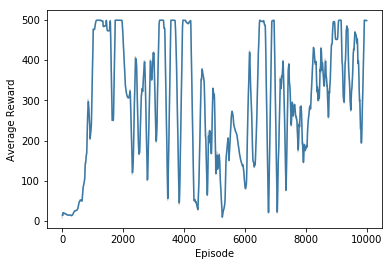

In [14]:
eps, rews = np.array(average_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average Reward')

Text(0, 0.5, 'Total Reward')

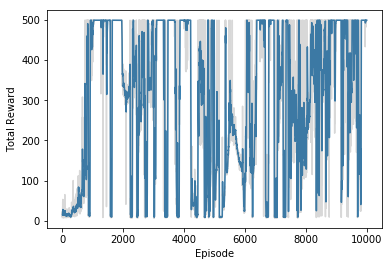

In [15]:
eps, rews = np.array(total_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

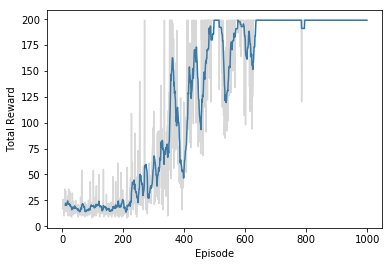

In [181]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [183]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.